In [1]:
# Stdlib packages
import copy
import datetime
import glob
import json
import os
import re
from pathlib import Path

# Common Py packages
import numpy as np
from matplotlib import pyplot as plt
from prettytable import PrettyTable

# HEP packages
import gpustat
import hist
import mplhep as hep
from cycler import cycler

# ML packages
import torch
import torch.nn as nn
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_curve, auc
from torch.utils.data import DataLoader

# Module packages
from AMSGrad import AMSGrad
from data_processing import process_data, data_list_index_map
from evaluate import evaluate
from InclusiveNetwork import InclusiveNetwork
from ParticleHLF import ParticleHLF
from space_optimization import optimize_hyperparams_RR
from train import train

gpustat.print_gpustat()
print(torch.cuda.is_available())

plt.style.use(hep.style.CMS)
plt.rcParams.update({'font.size': 20})
cmap_petroff10 = ["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6", "#a96b59", "#e76300", "#b9ac70", "#717581", "#92dadd"]
plt.rcParams.update({"axes.prop_cycle": cycler("color", cmap_petroff10)})

cmslpcgpu3.fnal.gov      Thu Dec 12 17:46:23 2024  555.42.06
[0] Tesla P100-PCIE-12GB | 41°C,   0 % |     2 / 12288 MB |
True


In [2]:
lpc_fileprefix = "/eos/uscms/store/group/lpcdihiggsboost/tsievert/HiggsDNA_parquet/v1"

# V2_MERGED = True

SIGNAL_FILEPATHS = [
    # Test sig files #
    # '/uscms/home/tsievert/nobackup/XHYbbgg/HiggsDNA_official/output_test_HH/Run3_2022preEE/GluGluToHH/nominal/*',
    # '/uscms/home/tsievert/nobackup/XHYbbgg/HiggsDNA_official/output_test_HH/Run3_2022preEE_merged_v2/GluGluToHH/nominal/*',
    # ggF HH # 
    # lpc_fileprefix+f"/Run3_2022preEE_merged{'_v2' if V2_MERGED else ''}/GluGluToHH/nominal/*", lpc_fileprefix+f"/Run3_2022postEE_merged{'_v2' if V2_MERGED else ''}/GluGluToHH/nominal/*",
    lpc_fileprefix+f"/Run3_2022preEE_merged_v3/GluGluToHH/nominal/*", lpc_fileprefix+f"/Run3_2022postEE_merged_v3/GluGluToHH/nominal/*",
    # VBF HH #
    # lpc_fileprefix+f"/Run3_2022preEE_merged{'_v2' if V2_MERGED else ''}/VBFHHto2B2G_CV_1_C2V_1_C3_1/nominal/*", lpc_fileprefix+f"/Run3_2022postEE_merged{'_v2' if V2_MERGED else ''}/VBFHHto2B2G_CV_1_C2V_1_C3_1/nominal/*",
]
BKG_FILEPATHS = [
    # ttH (i.e. the main bkg to reduce) #
    # lpc_fileprefix+f"/Run3_2022preEE_merged{'_v2' if V2_MERGED else ''}/ttHToGG/nominal/*", lpc_fileprefix+f"/Run3_2022postEE_merged{'_v2' if V2_MERGED else ''}/ttHToGG/nominal/*",
    lpc_fileprefix+f"/Run3_2022preEE_merged_v3/ttHToGG/nominal/*", lpc_fileprefix+f"/Run3_2022postEE_merged_v3/ttHToGG/nominal/*",
    # # Other single H samples #
    # lpc_fileprefix+f"/Run3_2022preEE_merged{'_v2' if V2_MERGED else ''}/GluGluHToGG/nominal/*", lpc_fileprefix+f"/Run3_2022postEE_merged{'_v2' if V2_MERGED else ''}/GluGluHToGG/nominal/*",
    # lpc_fileprefix+f"/Run3_2022preEE_merged{'_v2' if V2_MERGED else ''}/VBFHToGG/nominal/*", lpc_fileprefix+f"/Run3_2022postEE_merged{'_v2' if V2_MERGED else ''}/VBFHToGG/nominal/*",
    # lpc_fileprefix+f"/Run3_2022preEE_merged{'_v2' if V2_MERGED else ''}/VHToGG/nominal/*", lpc_fileprefix+f"/Run3_2022postEE_merged{'_v2' if V2_MERGED else ''}/VHToGG/nominal/*",
    # # Prompt-Prompt samples #
    # lpc_fileprefix+f"/Run3_2022preEE_merged{'_v2' if V2_MERGED else ''}/GGJets/nominal/*", lpc_fileprefix+f"/Run3_2022postEE_merged{'_v2' if V2_MERGED else ''}/GGJets/nominal/*",
    # # Prompt-Fake samples #
    # lpc_fileprefix+f"/Run3_2022preEE_merged{'_v2' if V2_MERGED else ''}/GJetPt20To40/nominal/*", lpc_fileprefix+f"/Run3_2022postEE_merged{'_v2' if V2_MERGED else ''}/GJetPt20To40/nominal/*",
    # lpc_fileprefix+f"/Run3_2022preEE_merged{'_v2' if V2_MERGED else ''}/GJetPt40/nominal/*", lpc_fileprefix+f"/Run3_2022postEE_merged{'_v2' if V2_MERGED else ''}/GJetPt40/nominal/*",
    # Fake-Fake samples #
    # ADD HERE #
]


CURRENT_DIRPATH = str(Path().absolute())
VERSION = 'v11'
CRITERION = "NLLLoss"
N_PARTICLES, N_PARTICLE_FIELDS = 6, 7
MOD_VALS = (5, 5)
# VARS = 'base_vars'
# VARS = 'extra_vars'
# CURRENT_TIME = '2024-08-30_14-35-01'
# VARS = 'extra_vars+'
# CURRENT_TIME = '2024-10-09_20-47-24'
VARS = 'extra_vars+max'
# CURRENT_TIME = '2024-10-29_00-47-20'
# CURRENT_TIME = '2024-10-21_12-09-38'
# CURRENT_TIME = '2024-11-20_18-34-50'
# VARS = 'extra_vars+max+opt_space'
# CURRENT_TIME = '2024-10-24_20-29-37'
# VARS = 'extra_vars+max+moved_vars_to_RNN'
# CURRENT_TIME = '2024-10-21_00-35-33'
# N_PARTICLES, N_PARTICLE_FIELDS = 6, 9
# VARS = 'extra_vars_no_dijet_mass'
# VARS = 'no_bad_vars'
# VARS = 'simplified_bad_vars'
# VARS = 'extra_vars_and_bools'
# VARS = 'extra_vars_in_RNN'
# VARS = f'extra_vars_mod{MOD_VALS[0]}-{MOD_VALS[1]}'
# VARS = 'extra_vars_lead_lep_only'
# CURRENT_TIME = '2024-10-02_18-03-26'
# N_PARTICLES, N_PARTICLE_FIELDS = 3, 6
# VARS = 'extra_vars_no_lep'
# CURRENT_TIME = '2024-10-04_12-49-31'
# N_PARTICLES, N_PARTICLE_FIELDS = 2, 6
if 'CURRENT_TIME' in globals():
    OUTPUT_DIRPATH = os.path.join(CURRENT_DIRPATH, f"model_outputs/{VERSION}/{VARS}", CURRENT_TIME)
else:
    OUTPUT_DIRPATH = os.path.join(CURRENT_DIRPATH, f"model_outputs/{VERSION}/{VARS}")

if not os.path.exists(OUTPUT_DIRPATH):
    os.makedirs(OUTPUT_DIRPATH)

SEED = 21
OPTIMIZE_SPACE = False
NUM_EPOCHS = 150

In [3]:
(
    data_df_dict, data_test_df_dict, 
    data_list_dict, data_hlf_dict, label_dict, 
    data_list_test_dict, data_hlf_test_dict, label_test_dict, 
    high_level_fields_dict, input_hlf_vars_dict, hlf_vars_columns_dict,
    data_aux_dict, data_test_aux_dict
) = process_data(
    N_PARTICLES, N_PARTICLE_FIELDS, SIGNAL_FILEPATHS, BKG_FILEPATHS, OUTPUT_DIRPATH, 
    seed=SEED, mod_vals=MOD_VALS, k_fold_test=True,
    save_std=False if 'CURRENT_TIME' in globals() else True
)


Data list: (413735, 6, 7)
Data HLF: (413735, 15)
n signal = 136530, n bkg = 277205
Data list test: (103521, 6, 7)
Data HLF test: (103521, 15)
n signal = 34224, n bkg = 69297
Data list: (413918, 6, 7)
Data HLF: (413918, 15)
n signal = 136466, n bkg = 277452
Data list test: (103338, 6, 7)
Data HLF test: (103338, 15)
n signal = 34288, n bkg = 69050
Data list: (413265, 6, 7)
Data HLF: (413265, 15)
n signal = 136638, n bkg = 276627
Data list test: (103991, 6, 7)
Data HLF test: (103991, 15)
n signal = 34116, n bkg = 69875
Data list: (413725, 6, 7)
Data HLF: (413725, 15)
n signal = 136671, n bkg = 277054
Data list test: (103531, 6, 7)
Data HLF test: (103531, 15)
n signal = 34083, n bkg = 69448
Data list: (414381, 6, 7)
Data HLF: (414381, 15)
n signal = 136711, n bkg = 277670
Data list test: (102875, 6, 7)
Data HLF test: (102875, 15)
n signal = 34043, n bkg = 68832


In [4]:
def training_weights(event_weights, labels):
    sum_of_bkg = np.sum(event_weights[labels==0])
    sum_of_sig = np.sum(event_weights[labels==1])

    sig_scale_factor = sum_of_bkg / sum_of_sig

    weights = np.where(labels==0, event_weights, event_weights*sig_scale_factor)
    mean_weight = np.mean(weights)
    abs_weights = np.abs(weights)
    scaled_weights = abs_weights / mean_weight

    return scaled_weights

def plot_train_val_losses(
    IN_info, plot_prefix, plot_postfix='', method='arr', labels=None, sort=None, n_folds=5
):
    plt.figure(figsize=(9,7))
    if method == 'std':
        plt.plot(
            range(len(IN_info['train_losses_arr'])), 
            IN_info['train_losses_arr'], label=f"Train data losses", 
            alpha=0.7
        )
        plt.plot(
            range(len(IN_info['train_losses_arr'])), 
            IN_info['val_losses_arr'], label=f"Validation data losses", 
            alpha=0.7
        )
    elif method == 'arr':
        linestyles = ['solid', 'dotted']
        linestyles = linestyles * ((2*len(IN_info['all_preds']) // len(linestyles)) + 1)
        linestyles = linestyles[:2*len(IN_info['all_preds'])]
        for fold_idx in range(n_folds):
            plt.plot(
                range(len(IN_info['train_losses_arr'][fold_idx])), 
                IN_info['train_losses_arr'][fold_idx], 
                label=f"Train data losses - fold {fold_idx}", alpha=0.5,
                linestyle=linestyles[fold_idx if fold_idx%2 == 0 else fold_idx+1]
            )
            plt.plot(
                range(len(IN_info['train_losses_arr'][fold_idx])), 
                IN_info['val_losses_arr'][fold_idx], 
                label=f"Validation data losses - fold {fold_idx}", alpha=0.5,
                linestyle=linestyles[fold_idx+1 if fold_idx%2 == 0 else fold_idx]
            )
    else:
        raise Exception(f"Must used methods 'std' or 'arr'. You used {method}.")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('EPOCH')
    plt.ylabel('Data Loss')
    plt.savefig(f'{plot_prefix}_train_val_losses{plot_postfix}.pdf', bbox_inches='tight')
    plt.savefig(f'{plot_prefix}_train_val_losses{plot_postfix}.png', bbox_inches='tight')
    plt.close()

def plot_roc(
    IN_info, plot_prefix, plot_postfix='', method='std', 
    labels=None, yscale='linear', run2=True, sort=None, run3=None,
    mask=None, n_folds=5
):
    run2_sigEff = [.9704, .9498, .9196, .7536, .5777, .3837]
    run2_bkgCont = [.2831, .2114, .1539, .0442, .0158, .0041]
    run2_bkgCont_err = [.0077, .0036, .0011, .0032, .0006, .0001]
    plt.figure(figsize=(9,7))
    if method == 'std':
        plt.plot(
            np.array(IN_info['mean_fprs'])[mask], np.array(IN_info['base_tpr'])[mask], 
            label="Run3 NN AUC = %.4f" % (IN_info['mean_area'])
        )
    elif method == 'round_robin':
        if mask is None:
            mask = np.ones(np.shape(IN_info['mean_fprs'])[0], dtype=bool)
        linestyles = ['dashed', 'dotted']
        linestyles = linestyles * ((len(IN_info['all_preds']) // len(linestyles)) + 1)
        linestyles = linestyles[:len(IN_info['all_preds'])]
        for fold_idx in range(n_folds):
            plt.plot(
                np.array(IN_info['fprs'][fold_idx])[mask], np.array(IN_info['base_tpr'])[mask],
                label="Run3 NN - fold %d, AUC = %.4f" % (fold_idx, float(auc(IN_info['fprs'][fold_idx],IN_info['base_tpr']))), linestyle=linestyles[fold_idx],
                alpha=0.5
            )
    elif method == 'round_robin_sum':
        if mask is None:
            mask = [np.ones(np.shape(IN_info['all_preds'][i])[0], dtype=bool) for i in range(n_folds)]

        base_tpr = np.linspace(0, 1, 5000)
        flat_preds = np.concatenate([
            np.exp(IN_info['all_preds'][i])[mask[i]][:, 1] for i in range(len(IN_info['all_preds']))
        ], axis=None)
        flat_labels = np.concatenate([
            np.array(IN_info['all_labels'][i])[mask[i]] for i in range(len(IN_info['all_preds']))
        ], axis=None)

        fpr, tpr, threshold = roc_curve(flat_labels, flat_preds)
        fpr = np.interp(base_tpr, tpr, fpr)
        threshold = np.interp(base_tpr, tpr, threshold)
        fpr[0] = 0.0

        all_auc = float(auc(fpr, base_tpr))

        plt.plot(
            fpr, base_tpr,
            label="Run3 NN - sum over folds, AUC = %.4f" % all_auc, linestyle='solid',
            alpha=1
        )
    elif method == 'round_robin_sum_arr':
        linestyles = ['solid', 'dashed', 'dotted']
        linestyles = linestyles * ((len(IN_info) // len(linestyles)) + 1)
        linestyles = linestyles[:len(IN_info)]
        if sort is not None:
            index_arr = sort
        else:
            index_arr = range(len(IN_info))
        for IN_idx in index_arr:
            if mask is None:
                mask = [np.ones(np.shape(IN_info[IN_idx]['all_preds'][i])[0], dtype=bool) for i in range(n_folds)]

            base_tpr = np.linspace(0, 1, 5000)
            flat_preds = np.concatenate([
                np.exp(IN_info[IN_idx]['all_preds'][i])[mask[i]][:, 1] for i in range(len(IN_info[IN_idx]['all_preds']))
            ], axis=None)
            flat_labels = np.concatenate([
                np.array(IN_info[IN_idx]['all_labels'][i])[mask[i]] for i in range(len(IN_info[IN_idx]['all_preds']))
            ], axis=None)

            fpr, tpr, threshold = roc_curve(flat_labels, flat_preds)
            fpr = np.interp(base_tpr, tpr, fpr)
            threshold = np.interp(base_tpr, tpr, threshold)
            fpr[0] = 0.0

            all_auc = float(auc(fpr, base_tpr))

            plt.plot(
                fpr, base_tpr,
                label=(labels[IN_idx]+', ' if labels is not None else '') + "AUC = %.4f" % all_auc, 
                linestyle=linestyles[IN_idx], alpha=0.8
            )
    elif method == 'arr':
        if mask is None:
            mask = np.ones(np.shape(IN_info['mean_fprs'])[0], dtype=bool)
        linestyles = ['dashed', 'dotted']
        linestyles = linestyles * ((len(IN_info['all_preds']) // len(linestyles)) + 1)
        linestyles = linestyles[:len(IN_info['all_preds'])]
        for fold_idx in range(n_folds):
            plt.plot(
                np.array(IN_info['fprs'][fold_idx])[mask], np.array(IN_info['base_tpr'])[mask],
                label="Run3 NN - fold %d" % (fold_idx), linestyle=linestyles[fold_idx],
                alpha=0.5
            )
        plt.plot(
            np.array(IN_info['mean_fprs'])[mask], np.array(IN_info['base_tpr'])[mask], 
            label="Run3 NN AUC = %.4f" % (IN_info['mean_area']),
            alpha=0.8
        )
    elif method == 'IN_arr':
        linestyles = ['solid', 'dashed', 'dotted']
        linestyles = linestyles * ((len(IN_info) // len(linestyles)) + 1)
        linestyles = linestyles[:len(IN_info)]
        if sort is not None:
            index_arr = sort
        else:
            index_arr = range(len(IN_info))
        for i in index_arr:
            if mask is None or np.all(mask):
                mask = np.ones(np.shape(IN_info[i]['mean_fprs'])[0], dtype=bool)
            plt.plot(
                np.array(IN_info[i]['mean_fprs'])[mask], np.array(IN_info[i]['base_tpr'])[mask], 
                label=(labels[i]+', ' if labels is not None else '') + "AUC = %.4f" % (IN_info[i]['mean_area']), 
                linestyle=linestyles[i], alpha=0.5
            )
    else:
        raise Exception(f"Must used methods 'std', 'arr', or 'IN_arr'. You used {method}.")
    if run2:
        plt.errorbar(run2_bkgCont, run2_sigEff, xerr=run2_bkgCont_err, label="Run2 NN AUC (val data) = {}".format(0.9469))
    if run3 is not None:
        if mask is None:
            mask = np.ones(np.shape(run3['mean_fprs'])[0], dtype=bool)
        plt.plot(
            np.array(run3['mean_fprs'])[mask], np.array(run3['base_tpr'])[mask], 
            label="Run3 NN AUC = %.4f" % (run3['mean_area']),
            alpha=0.8
        )
    if yscale is not None:
        plt.yscale(yscale)
    plt.ylim(0.1, 1.1)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('Background contamination')
    plt.ylabel('Signal efficiency')
    plt.savefig(f'{plot_prefix}_roc_curve{plot_postfix}.pdf', bbox_inches='tight')
    plt.savefig(f'{plot_prefix}_roc_curve{plot_postfix}.png', bbox_inches='tight')
    plt.close()

def plot_output_score(
        IN_info, plot_prefix, plot_postfix='', method='arr', labels=None, 
        weights={'sig': None, 'bkg': None}, n_bins=50, all_sig=False, all_bkg=False,
        mask=None, n_folds=5
    ):
    plt.figure(figsize=(9,7))
    if method == 'std':
        if mask is None:
            mask = np.ones(np.shape(IN_info['mean_pred'])[0], dtype=bool)
        sig_np = np.exp(
            IN_info['mean_pred']
        )[
            np.logical_and(
                np.array(IN_info['mean_label']) == 1, mask
            ),1
        ]
        bkg_np = np.exp(
            IN_info['mean_pred']
        )[
            np.logical_and(
                np.array(IN_info['mean_label']) == 0, mask
            ),1
        ]
        # for cut in np.linspace(0, 1, 10, endpoint=False):
        #     print(f"output score > {cut:.2f}")
        #     print('='*60)
        #     print(f"num sig > {cut:.2f} = {len(sig_np[sig_np > cut])}")
        #     print(f"num bkg > {cut:.2f} = {len(bkg_np[bkg_np > cut])}")
        #     print('-'*60)
        hist_axis = hist.axis.Regular(n_bins, 0., 1., name='var', growth=False, underflow=False, overflow=False)
        sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig_np, weight=weights['sig'] if weights['sig'] is not None else np.ones_like(sig_np))
        bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg_np, weight=weights['bkg'] if weights['sig'] is not None else np.ones_like(bkg_np))
        hep.histplot(
            [sig_hist, bkg_hist],
            yerr=(True if weights['sig'] is not None else False),
            alpha=0.7, density=(False if weights['sig'] is not None else True), histtype='step',
            label=['HH signal', 'ttH background']
        )
    elif method == 'round_robin':
        if mask is None:
            mask = [np.ones(np.shape(IN_info['all_preds'][i])[0], dtype=bool) for i in range(n_folds)]
        linestyles = ['dashed', 'dotted']
        linestyles = linestyles * ((len(IN_info['all_preds']) // len(linestyles)) + 1)
        linestyles = linestyles[:len(IN_info['all_preds'])]
        for fold_idx in range(n_folds):
            sig_np = np.exp(
                IN_info['all_preds'][fold_idx]
            )[
                np.logical_and(
                    np.array(IN_info['all_labels'][fold_idx]) == 1, mask[fold_idx]
                ),1
            ]
            bkg_np = np.exp(
                IN_info['all_preds'][fold_idx]
            )[
                np.logical_and(
                    np.array(IN_info['all_labels'][fold_idx]) == 0, mask[fold_idx]
                ),1
            ]
            hist_axis = hist.axis.Regular(n_bins, 0., 1., name='var', growth=False, underflow=False, overflow=False)
            sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig_np, weight=weights[fold_idx]['sig'] if weights[fold_idx]['sig'] is not None else np.ones_like(sig_np))
            bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg_np, weight=weights[fold_idx]['bkg'] if weights[fold_idx]['sig'] is not None else np.ones_like(bkg_np))
            hep.histplot(
                [sig_hist, bkg_hist],
                yerr=(True if weights[fold_idx]['sig'] is not None else False),
                alpha=0.5, density=(False if weights[fold_idx]['sig'] is not None else True), histtype='step',
                label=[
                    f'{"ggF HH" if not all_sig else "ggF HH + VBF HH"} signal'+(' - '+labels[fold_idx] if labels is not None else ''), 
                    f'{"ttH" if not all_bkg else "all"} background'+(' - '+labels[fold_idx] if labels is not None else '')
                ], linestyle=[linestyles[fold_idx], linestyles[fold_idx]]
            )
    elif method == 'round_robin_sum':
        if mask is None:
            mask = [np.ones(np.shape(IN_info['all_preds'][i])[0], dtype=bool) for i in range(n_folds)]

        flat_preds = np.concatenate([
            np.exp(IN_info['all_preds'][i])[mask[i]][:, 1] for i in range(len(IN_info['all_preds']))
        ], axis=None)
        flat_labels = np.concatenate([
            np.array(IN_info['all_labels'][i])[mask[i]] for i in range(len(IN_info['all_preds']))
        ], axis=None)
        sig_preds = flat_preds[flat_labels == 1]
        bkg_preds = flat_preds[flat_labels == 0]

        if weights[0]['sig'] is not None:
            sig_weight = np.concatenate([
                weight['sig'] for weight in weights.values()
            ], axis=None)
            bkg_weight = np.concatenate([
                weight['bkg'] for weight in weights.values()
            ], axis=None)
            full_weights = {'sig': sig_weight, 'bkg': bkg_weight}
        else:
            full_weights = {'sig': None, 'bkg': None}

        hist_axis = hist.axis.Regular(n_bins, 0., 1., name='var', growth=False, underflow=False, overflow=False)
        sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig_preds, weight=full_weights['sig'] if full_weights['sig'] is not None else np.ones_like(sig_preds))
        bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg_preds, weight=full_weights['bkg'] if full_weights['bkg'] is not None else np.ones_like(bkg_preds))
        hep.histplot(
            [sig_hist, bkg_hist],
            yerr=(True if full_weights['sig'] is not None else False),
            alpha=0.5, density=(False if full_weights['sig'] is not None else True), histtype='step',
            label=[
                f'{"ggF HH" if not all_sig else "ggF HH + VBF HH"} signal - sum over folds', 
                f'{"ttH" if not all_bkg else "all"} background - sum over folds'
            ], linestyle=['solid', 'solid']
        )
    elif method == 'arr':
        if mask is None:
            mask = np.ones(np.shape(IN_info['mean_pred'])[0], dtype=bool)
        linestyles = ['dashed', 'dotted']
        linestyles = linestyles * ((len(IN_info['all_preds']) // len(linestyles)) + 1)
        linestyles = linestyles[:len(IN_info['all_preds'])]
        for fold_idx in range(n_folds):
            sig_np = np.exp(
                IN_info['all_preds'][fold_idx]
            )[
                np.logical_and(
                    np.array(IN_info['all_labels'][fold_idx]) == 1, mask
                ),1
            ]
            bkg_np = np.exp(
                IN_info['all_preds'][fold_idx]
            )[
                np.logical_and(
                    np.array(IN_info['all_labels'][fold_idx]) == 0, mask
                ),1
            ]
            hist_axis = hist.axis.Regular(n_bins, 0., 1., name='var', growth=False, underflow=False, overflow=False)
            sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig_np, weight=weights['sig'] if weights['sig'] is not None else np.ones_like(sig_np))
            bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg_np, weight=weights['bkg'] if weights['sig'] is not None else np.ones_like(bkg_np))
            hep.histplot(
                [sig_hist, bkg_hist],
                yerr=(True if weights['sig'] is not None else False),
                alpha=0.5, density=(False if weights['sig'] is not None else True), histtype='step',
                label=[
                    f'{"ggF HH" if not all_sig else "ggF HH + VBF HH"} signal'+(' - '+labels[fold_idx] if labels is not None else ''), 
                    f'{"ttH" if not all_bkg else "all"} background'+(' - '+labels[fold_idx] if labels is not None else '')
                ], linestyle=[linestyles[fold_idx], linestyles[fold_idx]]
            )
        sig_np = np.exp(
            IN_info['mean_pred']
        )[
            np.logical_and(
                np.array(IN_info['mean_label']) == 1, mask
            ),1
        ]
        bkg_np = np.exp(
            IN_info['mean_pred']
        )[
            np.logical_and(
                np.array(IN_info['mean_label']) == 0, mask
            ),1
        ]
        hist_axis = hist.axis.Regular(n_bins, 0., 1., name='var', growth=False, underflow=False, overflow=False)
        sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig_np, weight=weights['sig'] if weights['sig'] is not None else np.ones_like(sig_np))
        bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg_np, weight=weights['bkg'] if weights['sig'] is not None else np.ones_like(bkg_np))
        hep.histplot(
            [sig_hist, bkg_hist],
            yerr=(True if weights['sig'] is not None else False),
            alpha=1, density=(False if weights['sig'] is not None else True), histtype='step',
            label=[
                f'{"ggF HH" if not all_sig else "ggF HH + VBF HH"} signal', 
                f'{"ttH" if not all_bkg else "all"} background'
            ]
        )
    elif method == 'IN_arr':
        linestyles = ['solid', 'dashed', 'dotted']
        linestyles = linestyles * ((len(IN_info) // len(linestyles)) + 1)
        linestyles = linestyles[:len(IN_info)]
        for i in range(len(IN_info)):
            if mask is None or np.all(mask):
                mask = np.ones(np.shape(IN_info[i]['mean_pred'])[0], dtype=bool)
            sig_np = np.exp(
                IN_info[i]['mean_pred']
            )[
                np.logical_and(
                    np.array(IN_info[i]['mean_label']) == 1, mask
                ),1
            ]
            bkg_np = np.exp(
                IN_info[i]['mean_pred']
            )[
                np.logical_and(
                    np.array(IN_info[i]['mean_label']) == 0, mask
                ),1
            ]
            hist_axis = hist.axis.Regular(n_bins, 0., 1., name='var', growth=False, underflow=False, overflow=False)
            sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig_np, weight=weights[i]['sig'] if weights[i]['sig'] is not None else np.ones_like(sig_np))
            bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg_np, weight=weights[i]['bkg'] if weights[i]['sig'] is not None else np.ones_like(bkg_np))
            hep.histplot(
                [sig_hist, bkg_hist],
                yerr=(True if weights[i]['sig'] is not None else False),
                alpha=0.7, density=(False if weights[i]['sig'] is not None else True), histtype='step',
                label=[
                    'HH signal'+(' - '+labels[i] if labels is not None else ''), 
                    'ttH background'+(' - '+labels[i] if labels is not None else '')
                ], linestyle=[linestyles[i], linestyles[i]]
            )
    else:
        raise Exception(f"Must used methods 'std', 'arr', or 'IN_arr'. You used {method}.")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.ylabel("Counts", fontsize=18)
    plt.xlabel("Threshold", fontsize=18)
    plt.savefig(f'{plot_prefix}_model_score_dist{plot_postfix}.pdf', bbox_inches='tight')
    plt.savefig(f'{plot_prefix}_model_score_dist{plot_postfix}.png', bbox_inches='tight')
    plt.close()

def s_over_root_b(
        IN_info, plot_prefix, plot_postfix='', method='arr', labels=None, 
        weights={'sig': None, 'bkg': None}, lines_fold=None, lines=None, lines_labels=None, 
        lines_colors=None, only_fold=None, no_fold=False, n_bins=50,
        mask=None, n_folds=5
    ):
    plt.figure(figsize=(9,7))
    if method == 'std':
        if mask is None:
            mask = np.ones(np.shape(IN_info['mean_pred'])[0], dtype=bool)
        sig_np = np.exp(
            IN_info['mean_pred']
        )[
            np.logical_and(
                np.array(IN_info['mean_label']) == 1, mask
            ),1
        ]
        bkg_np = np.exp(
            IN_info['mean_pred']
        )[
            np.logical_and(
                np.array(IN_info['mean_label']) == 0, mask
            ),1
        ]
        hist_axis = hist.axis.Regular(n_bins, 0., 1., name='var', growth=False, underflow=False, overflow=False)
        sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig_np, weight=weights['sig'])
        bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg_np, weight=weights['bkg'])
        s_over_root_b_points = sig_hist.values().flatten() / np.sqrt(bkg_hist.values().flatten())
        plt.plot(
            np.arange(0., 1., 1/n_bins), s_over_root_b_points, 
            label='s/√b', alpha=0.8 
        )
    elif method == 'round_robin':
        if mask is None:
            mask = [np.ones(np.shape(IN_info['all_preds'][i])[0], dtype=bool) for i in range(n_folds)]
        linestyles = ['dashed', 'dotted']
        linestyles = linestyles * ((len(IN_info['all_preds']) // len(linestyles)) + 1)
        linestyles = linestyles[:len(IN_info['all_preds'])]
        for fold_idx in range(n_folds):
            if (only_fold is not None and fold_idx != only_fold) or no_fold == True:
                continue
            sig_np = np.exp(
                IN_info['all_preds'][fold_idx]
            )[
                np.logical_and(
                    np.array(IN_info['all_labels'][fold_idx]) == 1, mask[fold_idx]
                ),1
            ]
            bkg_np = np.exp(
                IN_info['all_preds'][fold_idx]
            )[
                np.logical_and(
                    np.array(IN_info['all_labels'][fold_idx]) == 0, mask[fold_idx]
                ),1
            ]
            hist_axis = hist.axis.Regular(n_bins, 0., 1., name='var', growth=False, underflow=False, overflow=False)
            sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig_np, weight=weights[fold_idx]['sig'])
            bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg_np, weight=weights[fold_idx]['bkg'])
            s_over_root_b_points = sig_hist.values().flatten() / np.sqrt(bkg_hist.values().flatten())
            plt.plot(
                np.arange(0., 1., 1/n_bins), s_over_root_b_points, 
                label='s/√b'+(' - fold '+labels[fold_idx] if labels is not None else ''), 
                alpha=0.5, linestyle=linestyles[fold_idx], 
            )
            if lines_fold is not None:
                for i in range(len(lines_fold[fold_idx])):
                    plt.vlines(
                        lines_fold[fold_idx][i], 0, np.max(s_over_root_b_points), 
                        label='s/√b'+(' - '+lines_labels[fold_idx][i] if lines_labels is not None else ''), 
                        alpha=0.5, colors=lines_colors[fold_idx][i]
                    )
    elif method == 'round_robin_sum':
        if mask is None:
            mask = [np.ones(np.shape(IN_info['all_preds'][i])[0], dtype=bool) for i in range(n_folds)]

        flat_preds = np.concatenate([
            np.exp(IN_info['all_preds'][i])[mask[i]][:, 1] for i in range(len(IN_info['all_preds']))
        ], axis=None)
        flat_labels = np.concatenate([
            np.array(IN_info['all_labels'][i])[mask[i]] for i in range(len(IN_info['all_preds']))
        ], axis=None)
        sig_preds = flat_preds[flat_labels == 1]
        bkg_preds = flat_preds[flat_labels == 0]
        
        sig_weight = np.concatenate([
            weight['sig'] for weight in weights.values()
        ], axis=None)
        bkg_weight = np.concatenate([
            weight['bkg'] for weight in weights.values()
        ], axis=None)
        full_weights = {'sig': sig_weight, 'bkg': bkg_weight}

        hist_axis = hist.axis.Regular(n_bins, 0., 1., name='var', growth=False, underflow=False, overflow=False)
        sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig_preds, weight=full_weights['sig'] if full_weights['sig'] is not None else np.ones_like(sig_preds))
        bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg_preds, weight=full_weights['bkg'] if full_weights['bkg'] is not None else np.ones_like(bkg_preds))
        s_over_root_b_points = sig_hist.values().flatten() / np.sqrt(bkg_hist.values().flatten())
        plt.plot(
            np.arange(0., 1., 1/n_bins), s_over_root_b_points, 
            label='s/√b - sum over folds', 
            alpha=0.5, linestyle='solid', 
        )
        if lines is not None:
            for i in range(len(lines)):
                plt.vlines(
                    lines[i], 0, np.max(s_over_root_b_points), 
                    label='s/√b'+(' - '+lines_labels[i] if lines_labels is not None else ''), 
                    alpha=0.5, colors=lines_colors[i]
                )
    elif method == 'arr':
        if mask is None or np.all(mask):
            mask = np.ones(np.shape(IN_info['mean_pred'])[0], dtype=bool)
        linestyles = ['dashed', 'dotted']
        linestyles = linestyles * ((len(IN_info['all_preds']) // len(linestyles)) + 1)
        linestyles = linestyles[:len(IN_info['all_preds'])]
        for fold_idx in range(n_folds):
            if (only_fold is not None and fold_idx != only_fold) or no_fold == True:
                continue
            sig_np = np.exp(
                IN_info['all_preds'][fold_idx]
            )[
                np.logical_and(
                    np.array(IN_info['all_labels'][fold_idx]) == 1, mask
                ),1
            ]
            bkg_np = np.exp(
                IN_info['all_preds'][fold_idx]
            )[
                np.logical_and(
                    np.array(IN_info['all_labels'][fold_idx]) == 0, mask
                ),1
            ]
            hist_axis = hist.axis.Regular(n_bins, 0., 1., name='var', growth=False, underflow=False, overflow=False)
            sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig_np, weight=weights['sig'])
            bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg_np, weight=weights['bkg'])
            s_over_root_b_points = sig_hist.values().flatten() / np.sqrt(bkg_hist.values().flatten())
            plt.plot(
                np.arange(0., 1., 1/n_bins), s_over_root_b_points, 
                label='s/√b'+(' - fold '+labels[fold_idx] if labels is not None else ''), 
                alpha=0.5, linestyle=linestyles[fold_idx], 
            )
            if lines_fold is not None:
                for i in range(len(lines_fold[fold_idx])):
                    plt.vlines(
                        lines_fold[fold_idx][i], 0, np.max(s_over_root_b_points), 
                        label='s/√b'+(' - '+lines_labels[fold_idx][i] if lines_labels is not None else ''), 
                        alpha=0.5, colors=lines_colors[fold_idx][i]
                    )
        if only_fold is None:
            sig_np = np.exp(
            IN_info['mean_pred']
            )[
                np.logical_and(
                    np.array(IN_info['mean_label']) == 1, mask
                ),1
            ]
            bkg_np = np.exp(
                IN_info['mean_pred']
            )[
                np.logical_and(
                    np.array(IN_info['mean_label']) == 0, mask
                ),1
            ]
            hist_axis = hist.axis.Regular(n_bins, 0., 1., name='var', growth=False, underflow=False, overflow=False)
            sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig_np, weight=weights['sig'])
            bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg_np, weight=weights['bkg'])
            s_over_root_b_points = sig_hist.values().flatten() / np.sqrt(bkg_hist.values().flatten())
            plt.plot(
                np.arange(0., 1., 1/n_bins), s_over_root_b_points, 
                label='s/√b - avg. over folds', 
                alpha=0.5, 
            )
            if lines is not None:
                for i in range(len(lines)):
                    plt.vlines(
                        lines[i], 0, np.max(s_over_root_b_points), 
                        label='s/√b - avg.'+(' - '+lines_labels[i] if lines_labels is not None else ''), 
                        alpha=0.5, colors=lines_colors[i]
                    )
    elif method == 'IN_arr':
        linestyles = ['solid', 'dashed', 'dotted']
        linestyles = linestyles * ((len(IN_info) // len(linestyles)) + 1)
        linestyles = linestyles[:len(IN_info)]
        for i in range(len(IN_info)):
            if mask is None or np.all(mask):
                mask = np.ones(np.shape(IN_info[i]['mean_pred'])[0], dtype=bool)
            sig_np = np.exp(
                IN_info[i]['mean_pred']
            )[
                np.logical_and(
                    np.array(IN_info[i]['mean_label']) == 1, mask
                ),1
            ]
            bkg_np = np.exp(
                IN_info[i]['mean_pred']
            )[
                np.logical_and(
                    np.array(IN_info[i]['mean_label']) == 0, mask
                ),1
            ]
            hist_axis = hist.axis.Regular(n_bins, 0., 1., name='var', growth=False, underflow=False, overflow=False)
            sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig_np, weight=weights[i]['sig'])
            bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg_np, weight=weights[i]['bkg'])
            plt.plot(
                np.arange(0., 1., 1/n_bins), sig_hist.values().flatten() / np.sqrt(bkg_hist.values().flatten()), 
                label='s/√b'+(' - '+labels[i] if labels is not None else ''), 
                alpha=0.5, linestyle=linestyles[i], 
            )
    else:
        raise Exception(f"Must used methods 'std', 'arr', or 'IN_arr'. You used {method}.")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.ylabel("s/√b", fontsize=18)
    plt.xlabel("Threshold", fontsize=18)
    plt.savefig(f'{plot_prefix}_model_s_over_b{plot_postfix}.pdf', bbox_inches='tight')
    plt.savefig(f'{plot_prefix}_model_s_over_b{plot_postfix}.png', bbox_inches='tight')
    plt.close()
    

In [5]:
MC_NAMES_PRETTY = {
    "GGJets": r"$\gamma\gamma+3j$",
    "GJetPt20To40": r"$\gamma+j$, 20<$p_T$<40GeV",
    "GJetPt40": r"$\gamma+j$, 40GeV<$p_T$",
    "GluGluHToGG": r"ggF $H\rightarrow \gamma\gamma$",
    "VBFHToGG": r"VBF $H\rightarrow \gamma\gamma$",
    "VHToGG": r"V$H\rightarrow\gamma\gamma$",
    "ttHToGG": r"$t\bar{t}H\rightarrow\gamma\gamma$",
    "GluGluToHH": r"ggF $HH\rightarrow bb\gamma\gamma$",
    "signal": r"ggF $HH\rightarrow bb\gamma\gamma$ + VBF $HH\rightarrow bb\gamma\gamma$"
    # "VBFHHto2B2G_CV_1_C2V_1_C3_1": r"VBF $HH\rightarrow bb\gamma\gamma$",
    # Need to fill in pretty print for BSM samples #
}
LUMINOSITIES = {
    '2022preEE': 7.9804, 
    '2022postEE': 26.6717,
    # Need to fill in lumis for other eras #
}
LUMINOSITIES['total_lumi'] = sum(LUMINOSITIES.values())

# Dictionary of variables
VARIABLES = {
    # key: hist.axis axes for plotting #
    # MET variables
    'puppiMET_sumEt': hist.axis.Regular(40, 150., 2000, name='var', label=r'puppiMET $\Sigma E_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'puppiMET_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'puppiMET $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'puppiMET_phi': hist.axis.Regular(20,-3.2, 3.2, name='var', label=r'puppiMET $\phi$', growth=False, underflow=False, overflow=False), 
    # jet-MET variables
    'DeltaPhi_j1MET': hist.axis.Regular(20,-3.2, 3.2, name='var', label=r'$\Delta\phi (j_1,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
    'DeltaPhi_j2MET': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'$\Delta\phi (j_2,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
    # jet-photon variables
    'DeltaR_jg_min': hist.axis.Regular(30, 0, 5, name='var', label=r'min$(\Delta R(jet, \gamma))$', growth=False, underflow=False, overflow=False), 
    # jet variables
    # 'jet1_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'lead jet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
    # 'jet2_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'sublead jet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
    'lead_bjet_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'lead bjet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
    'lead_bjet_eta': hist.axis.Regular(20, -5., 5., name='var', label=r'lead bjet $\eta$', growth=False, underflow=False, overflow=False),
    'lead_bjet_phi': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'lead bjet $\phi$', growth=False, underflow=False, overflow=False),
    'sublead_bjet_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'lead bjet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
    'sublead_bjet_eta': hist.axis.Regular(20, -5., 5., name='var', label=r'lead bjet $\eta$', growth=False, underflow=False, overflow=False),
    'sublead_bjet_phi': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'lead bjet $\phi$', growth=False, underflow=False, overflow=False),
    'n_jets': hist.axis.Integer(0, 10, name='var', label=r'$n_{jets}$', growth=False, underflow=False, overflow=False), 
    'chi_t0': hist.axis.Regular(40, 0., 150, name='var', label=r'$\chi_{t0}^2$', growth=False, underflow=False, overflow=False), 
    'chi_t1': hist.axis.Regular(30, 0., 500, name='var', label=r'$\chi_{t1}^2$', growth=False, underflow=False, overflow=False), 
    # lepton variables
    'n_leptons': hist.axis.Integer(0, 10, name='var', label=r'$n_{leptons}$', growth=False, underflow=False, overflow=False),
    'lepton1_pt': hist.axis.Regular(40, 0., 200., name='var', label=r'lead lepton $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'lepton2_pt': hist.axis.Regular(40, 0., 200., name='var', label=r'sublead lepton $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'lepton1_eta': hist.axis.Regular(30, -5., 5., name='var', label=r'lead lepton $\eta$', growth=False, underflow=False, overflow=False), 
    'lepton2_eta': hist.axis.Regular(30, -5., 5., name='var', label=r'sublead lepton $\eta$', growth=False, underflow=False, overflow=False),
    'lepton1_phi': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'lead lepton $\phi$', growth=False, underflow=False, overflow=False), 
    'lepton2_phi': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'sublead lepton $\phi$', growth=False, underflow=False, overflow=False),
    # diphoton variables
    'pt': hist.axis.Regular(40, 20., 2000, name='var', label=r' $\gamma\gamma p_{T}$ [GeV]', growth=False, underflow=False, overflow=False),
    'eta': hist.axis.Regular(20, -5., 5., name='var', label=r'$\gamma\gamma \eta$', growth=False, underflow=False, overflow=False), 
    'phi': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'$\gamma \gamma \phi$', growth=False, underflow=False, overflow=False),
    # angular (cos) variables
    'abs_CosThetaStar_CS': hist.axis.Regular(20, 0, 1, name='var', label=r'|cos$(\theta_{CS})$|', growth=False, underflow=False, overflow=False), 
    'abs_CosThetaStar_jj': hist.axis.Regular(20, 0, 1, name='var', label=r'|cos$(\theta_{jj})$|', growth=False, underflow=False, overflow=False),
    'CosThetaStar_CS': hist.axis.Regular(20, -1, 1, name='var', label=r'cos$(\theta_{CS})$', growth=False, underflow=False, overflow=False), 
    'CosThetaStar_jj': hist.axis.Regular(20, -1, 1, name='var', label=r'cos$(\theta_{jj})$', growth=False, underflow=False, overflow=False), 
    # jet-lepton variables
    'leadBjet_leadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{lead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
    'leadBjet_subleadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{lead}, l_{sublead})$', growth=False, underflow=False, overflow=False), 
    'subleadBjet_leadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{sublead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
    'subleadBjet_subleadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{sublead}, l_{sublead})$', growth=False, underflow=False, overflow=False),
    # dijet variables (must be blinded on data)
    'dijet_mass': hist.axis.Regular(50, 25., 180., name='var', label=r'$M_{jj}$ [GeV]', growth=False, underflow=False, overflow=False),
    # diphoton variables (must be blinded on data)
    'mass': hist.axis.Regular(50, 25., 180., name='var', label=r'$M_{\gamma\gamma}$ [GeV]', growth=False, underflow=False, overflow=False),
}
# Dictionary of variables to do MC/Data comparison
VARIABLES_STD = {
    # key: hist.axis axes for plotting #
    # MET variables
    'puppiMET_sumEt': hist.axis.Regular(40, -4., 4., name='var', label=r'puppiMET ln($\Sigma E_T$) [GeV]', growth=False, underflow=False, overflow=False), 
    'puppiMET_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'puppiMET ln($p_T$) [GeV]', growth=False, underflow=False, overflow=False), 
    'puppiMET_phi': hist.axis.Regular(40, -4., 4., name='var', label=r'puppiMET $\phi$', growth=False, underflow=False, overflow=False), 
    # jet-MET variables
    'DeltaPhi_j1MET': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta\phi (j_1,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
    'DeltaPhi_j2MET': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta\phi (j_2,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
    # jet-photon variables
    'DeltaR_jg_min': hist.axis.Regular(40, -4., 4., name='var', label=r'min$(\Delta R(jet, \gamma))$', growth=False, underflow=False, overflow=False), 
    # jet variables
    'lead_bjet_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'lead bjet ln($p_T$) [GeV]', growth=False, underflow=False, overflow=False), 
    'sublead_bjet_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead bjet ln($p_T$) [GeV]', growth=False, underflow=False, overflow=False), 
    'lead_bjet_eta': hist.axis.Regular(40, -4., 4., name='var', label=r'lead bjet $\eta$', growth=False, underflow=False, overflow=False), 
    'sublead_bjet_eta': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead bjet $\eta$', growth=False, underflow=False, overflow=False),
    'lead_bjet_phi': hist.axis.Regular(40, -4., 4., name='var', label=r'lead bjet $\phi$', growth=False, underflow=False, overflow=False), 
    'sublead_bjet_phi': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead bjet $\phi$', growth=False, underflow=False, overflow=False),
    'n_jets': hist.axis.Regular(12, -4., 4., name='var', label=r'$n_{jets}$', growth=False, underflow=False, overflow=False), 
    'chi_t0': hist.axis.Regular(40, -4., 10., name='var', label=r'ln($\chi_{t0}^2$)', growth=False, underflow=False, overflow=False), 
    'chi_t1': hist.axis.Regular(40, -4., 10., name='var', label=r'ln($\chi_{t1}^2$)', growth=False, underflow=False, overflow=False), 
    # lepton variables
    'n_leptons': hist.axis.Regular(12, -4., 4., name='var', label=r'$n_{leptons}$', growth=False, underflow=False, overflow=False),
    'lepton1_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'lead lepton ln($p_T$) [GeV]', growth=False, underflow=False, overflow=False), 
    'lepton2_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead lepton ln($p_T$) [GeV]', growth=False, underflow=False, overflow=False), 
    'lepton1_eta': hist.axis.Regular(40, -4., 4., name='var', label=r'lead lepton $\eta$', growth=False, underflow=False, overflow=False), 
    'lepton2_eta': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead lepton $\eta$', growth=False, underflow=False, overflow=False),
    'lepton1_phi': hist.axis.Regular(40, -4., 4., name='var', label=r'lead lepton $\phi$', growth=False, underflow=False, overflow=False), 
    'lepton2_phi': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead lepton $\phi$', growth=False, underflow=False, overflow=False),
    # diphoton variables
    'pt': hist.axis.Regular(40, -4., 4., name='var', label=r' $\gamma\gamma$ ln($p_{T}$) [GeV]', growth=False, underflow=False, overflow=False),
    'eta': hist.axis.Regular(40, -4., 4., name='var', label=r'$\gamma\gamma \eta$', growth=False, underflow=False, overflow=False), 
    'phi': hist.axis.Regular(40, -4., 4., name='var', label=r'$\gamma \gamma \phi$', growth=False, underflow=False, overflow=False),
    # angular (cos) variables
    'abs_CosThetaStar_CS': hist.axis.Regular(40, -4., 4., name='var', label=r'|cos$(\theta_{CS})$|', growth=False, underflow=False, overflow=False), 
    'abs_CosThetaStar_jj': hist.axis.Regular(40, -4., 4., name='var', label=r'|cos$(\theta_{jj})$|', growth=False, underflow=False, overflow=False), 
    'CosThetaStar_CS': hist.axis.Regular(40, -1., 1., name='var', label=r'cos$(\theta_{CS})$', growth=False, underflow=False, overflow=False), 
    'CosThetaStar_jj': hist.axis.Regular(40, -1., 1., name='var', label=r'cos$(\theta_{jj})$', growth=False, underflow=False, overflow=False), 
    # jet-lepton variables
    'leadBjet_leadLepton': hist.axis.Regular(40, -4., 4. if re.search('vars_to_RNN', VARS) is not None else 10., name='var', label=r'$\Delta R(bjet_{lead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
    'leadBjet_subleadLepton': hist.axis.Regular(40, -4., 4. if re.search('vars_to_RNN', VARS) is not None else 10., name='var', label=r'$\Delta R(bjet_{lead}, l_{sublead})$', growth=False, underflow=False, overflow=False), 
    'subleadBjet_leadLepton': hist.axis.Regular(40, -4., 4. if re.search('vars_to_RNN', VARS) is not None else 10., name='var', label=r'$\Delta R(bjet_{sublead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
    'subleadBjet_subleadLepton': hist.axis.Regular(40, -4., 4. if re.search('vars_to_RNN', VARS) is not None else 10., name='var', label=r'$\Delta R(bjet_{sublead}, l_{sublead})$', growth=False, underflow=False, overflow=False),
    # dijet variables (must be blinded on data)
    'dijet_mass': hist.axis.Regular(40, -4., 4., name='var', label=r'ln($M_{jj}$) [GeV]', growth=False, underflow=False, overflow=False),
    # diphoton variables (must be blinded on data)
    'mass': hist.axis.Regular(40, -4., 4., name='var', label=r'$M_{\gamma\gamma}$ [GeV]', growth=False, underflow=False, overflow=False),
}

def post_std_np_arrays(
        data, data_test, fold, var_name, train_index=None, val_index=None
):
    sig_mask = label_dict[f'fold_{fold}'] == 1
    sig_test_mask = label_test_dict[f'fold_{fold}'] == 1
    bkg_mask = label_dict[f'fold_{fold}'] == 0
    bkg_test_mask = label_test_dict[f'fold_{fold}'] == 0
    if train_index is not None and val_index is not None:
        sig_train_mask = sig_mask & train_index 
        sig_val_mask = sig_mask & val_index
        bkg_train_mask = bkg_mask & train_index
        bkg_val_mask = bkg_mask & val_index
        if var_name in (high_level_fields_dict[f'fold_{fold}'] - set(input_hlf_vars_dict[f'fold_{fold}'])):
            sig_train_np = data[data_list_index_map(var_name, data, sig_train_mask, n_pFields=N_PARTICLE_FIELDS)]
            sig_val_np = data[data_list_index_map(var_name, data, sig_val_mask, n_pFields=N_PARTICLE_FIELDS)]
            sig_test_np = data_test[data_list_index_map(var_name, data_test, sig_test_mask, n_pFields=N_PARTICLE_FIELDS)]
            bkg_train_np = data[data_list_index_map(var_name, data, bkg_train_mask, n_pFields=N_PARTICLE_FIELDS)]
            bkg_val_np = data[data_list_index_map(var_name, data, bkg_val_mask, n_pFields=N_PARTICLE_FIELDS)]
            bkg_test_np = data_test[data_list_index_map(var_name, data_test, bkg_test_mask, n_pFields=N_PARTICLE_FIELDS)]
        else:
            index2 = hlf_vars_columns_dict[f'fold_{fold}'][var_name]
            sig_train_np = data[sig_train_mask, index2]
            sig_val_np = data[sig_val_mask, index2]
            sig_test_np = data_test[sig_test_mask, index2]
            bkg_train_np = data[bkg_train_mask, index2]
            bkg_val_np = data[bkg_val_mask, index2]
            bkg_test_np = data_test[bkg_test_mask, index2]

        return (
            sig_train_np, sig_val_np, sig_test_np, 
            bkg_train_np, bkg_val_np, bkg_test_np
        )
    elif train_index is None and val_index is None:
        if var_name in (high_level_fields_dict[f'fold_{fold}'] - set(input_hlf_vars_dict[f'fold_{fold}'])):
            # index2, index3 = index_map[var_name]
            sig_train_np = data[data_list_index_map(var_name, data, sig_mask, n_pFields=N_PARTICLE_FIELDS)]
            sig_test_np = data_test[data_list_index_map(var_name, data_test, sig_test_mask, n_pFields=N_PARTICLE_FIELDS)]
            bkg_train_np = data[data_list_index_map(var_name, data, bkg_mask, n_pFields=N_PARTICLE_FIELDS)]
            bkg_test_np = data_test[data_list_index_map(var_name, data_test, bkg_test_mask, n_pFields=N_PARTICLE_FIELDS)]
        else:
            index2 = hlf_vars_columns_dict[f'fold_{fold}'][var_name]
            sig_train_np = data[sig_mask, index2]
            sig_test_np = data_test[sig_test_mask, index2]
            bkg_train_np = data[bkg_mask, index2]
            bkg_test_np = data_test[bkg_test_mask, index2]
        return (
            copy.deepcopy(sig_train_np), copy.deepcopy(sig_test_np), 
            copy.deepcopy(bkg_train_np), copy.deepcopy(bkg_test_np)
        )
    else:
        raise Exception("Either both train_index and val_index must be 'None', or both should not be 'None'. You cannot mix and match.")

def aux_np_arrays(var_name, score_cut, IN_full_eval_dict, fold):
    sig_train_mask = (label_dict[f'fold_{fold}'] == 1) & (
        np.exp(IN_full_eval_dict['train']['all_preds'][fold])[:, 1] > score_cut
    )
    sig_test_mask = (label_test_dict[f'fold_{fold}'] == 1) & (
        np.exp(IN_full_eval_dict['test']['all_preds'][fold])[:, 1] > score_cut
    )
    bkg_train_mask = (label_dict[f'fold_{fold}'] == 0) & (
        np.exp(IN_full_eval_dict['train']['all_preds'][fold])[:, 1] > score_cut
    )
    bkg_test_mask = (label_test_dict[f'fold_{fold}'] == 0) & (
        np.exp(IN_full_eval_dict['test']['all_preds'][fold])[:, 1] > score_cut
    )

    sig_train_np = data_aux_dict[f'fold_{fold}'].loc[sig_train_mask, var_name].to_numpy()
    sig_test_np = data_test_aux_dict[f'fold_{fold}'].loc[sig_test_mask, var_name].to_numpy()
    bkg_train_np = data_aux_dict[f'fold_{fold}'].loc[bkg_train_mask, var_name].to_numpy()
    bkg_test_np = data_test_aux_dict[f'fold_{fold}'].loc[bkg_test_mask, var_name].to_numpy()

    return (
        copy.deepcopy(sig_train_np), copy.deepcopy(sig_test_np), 
        copy.deepcopy(bkg_train_np), copy.deepcopy(bkg_test_np)
    )

def make_input_plot(
    output_dir, var_name, hist_list, fold_idx=None, labels=None, density=True, 
    plot_prefix='', plot_postfix='', alpha=0.8, linestyle=True
):
    fig, ax = plt.subplots()
    if linestyle:
        if fold_idx is not None:
            linestyles = ["solid", "dashed", "dotted", "solid", "dashed", "dotted"]
        else:
            linestyles = ["solid", "dotted", "solid", "dotted"]
        linestyles = linestyles * ((len(hist_list) // len(linestyles)) + 1)
        linestyles = linestyles[:len(hist_list)]
    else:
        linestyles = None
    hep.histplot(
        hist_list, ax=ax, linewidth=3, histtype="step", yerr=True, density=density,
        linestyle=linestyles, label=labels, alpha=alpha
    )
    # Plotting niceties #
    hep.cms.lumitext(f"{LUMINOSITIES['total_lumi']:.2f}" + r"fb$^{-1}$ (13.6 TeV)", ax=ax)
    hep.cms.text("Work in Progress", ax=ax)
    # Plot legend properly
    ax.legend(bbox_to_anchor=(1, 0.5))
    # Make angular and chi^2 plots linear, otherwise log
    if re.match('chi_t', var_name) is None and re.match('DeltaPhi', var_name) is None and re.match('mass', var_name) is None:
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
    ax.set_yscale('linear')
    # Save out the plot
    if fold_idx is not None:
        output_dir_ = os.path.join(output_dir, "fold")
        if not os.path.exists(output_dir_):
            os.makedirs(output_dir_)
        plt.savefig(f'{output_dir_}/{plot_prefix}1dhist_{var_name}{plot_postfix}_fold{fold_idx}.pdf', bbox_inches='tight')
        plt.savefig(f'{output_dir_}/{plot_prefix}1dhist_{var_name}{plot_postfix}_fold{fold_idx}.png', bbox_inches='tight')
    else:
        plt.savefig(f'{output_dir}/{plot_prefix}1dhist_{var_name}{plot_postfix}.pdf', bbox_inches='tight')
        plt.savefig(f'{output_dir}/{plot_prefix}1dhist_{var_name}{plot_postfix}.png', bbox_inches='tight')
    plt.close()

def plot_input_vars_after_score_cut(
    IN_info, score_cut, destdir, fold, plot_prefix, plot_postfix='', method='std', 
    weights={'sig': None, 'bkg': None}, all_sig=False, all_bkg=False,
    mask=None
):
    if method == 'std':
        if mask is None:
            mask = np.ones(np.shape(IN_info['mean_pred'])[0], dtype=bool)
        sig_mask = np.exp(
            IN_info['mean_pred']
        )[
            np.logical_and(
                np.array(IN_info['mean_label']) == 1, mask
            ),1
        ] > score_cut
        bkg_mask = np.exp(
            IN_info['mean_pred']
        )[
            np.logical_and(
                np.array(IN_info['mean_label']) == 0, mask
            ),1
        ] > score_cut

        for var_name in high_level_fields_dict[f'fold_{fold}']:
            if var_name in {'event', 'puppiMET_eta'}:
                continue
            sig_var = data_test_df_dict[f'fold_{fold}'].loc[(label_test_dict[f'fold_{fold}']==1) & mask, var_name]
            sig_hist = hist.Hist(VARIABLES[var_name]).fill(
                var=sig_var.loc[sig_mask], 
                weight=weights['sig'][sig_mask] if weights['sig'] is not None else np.ones(np.sum(sig_mask))
            )
            bkg_var = data_test_df_dict[f'fold_{fold}'].loc[(label_test_dict[f'fold_{fold}']==0) & mask, var_name]
            bkg_hist = hist.Hist(VARIABLES[var_name]).fill(
                var=bkg_var.loc[bkg_mask], 
                weight=weights['bkg'][bkg_mask] if weights['bkg'] is not None else np.ones(np.sum(bkg_mask))
            )
            make_input_plot(
                destdir, var_name, [sig_hist, bkg_hist], fold, plot_prefix=plot_prefix, 
                plot_postfix=plot_postfix+f'_ttHscore{score_cut}', labels=['HH signal', 'ttH background'], density=False if weights['sig'] is not None else True
            )
    elif method == 'round_robin':
        if mask is None:
            mask = np.ones(np.shape(IN_info['all_preds'][fold])[0], dtype=bool)
        
        for var_name in high_level_fields_dict[f'fold_{fold}']:
            if var_name in {'event', 'puppiMET_eta'}:
                continue
            sig_var = data_test_df_dict[f'fold_{fold}'].loc[(label_test_dict[f'fold_{fold}']==1) & mask, var_name]
            bkg_var = data_test_df_dict[f'fold_{fold}'].loc[(label_test_dict[f'fold_{fold}']==0) & mask, var_name]
            sig_masks, bkg_masks = [], []
            hists, labels = [], []
            for cut in score_cut if score_cut is list else [score_cut]:
                sig_masks.append(np.exp(
                    IN_info['all_preds'][fold]
                )[
                    np.logical_and(
                        np.array(IN_info['all_labels'][fold]) == 1, mask
                    ),1
                ] > cut)
                bkg_masks.append(np.exp(
                    IN_info['all_preds'][fold]
                )[
                    np.logical_and(
                        np.array(IN_info['all_labels'][fold]) == 0, mask
                    ),1
                ] > cut)
                
                hists.append(hist.Hist(VARIABLES[var_name]).fill(
                    var=sig_var.loc[sig_masks[-1]], 
                    weight=weights['sig'][sig_masks[-1]] if weights['sig'] is not None else np.ones(np.sum(sig_masks[-1]))
                ))
                hists.append(hist.Hist(VARIABLES[var_name]).fill(
                    var=bkg_var.loc[bkg_masks[-1]], 
                    weight=weights['bkg'][bkg_masks[-1]] if weights['bkg'] is not None else np.ones(np.sum(bkg_masks[-1]))
                ))
                labels.extend([f'HH signal, ttH-score > {cut}', f'ttH background, ttH-score > {cut}'])
            make_input_plot(
                destdir, var_name, hists, fold, plot_prefix=plot_prefix, 
                plot_postfix=plot_postfix+f'_ttHscore_scan', labels=labels, density=False if weights['sig'] is not None else True
            )
    elif method == 'arr':
        if mask is None:
            mask = np.ones(np.shape(IN_info['mean_pred'])[0], dtype=bool)
        for var_name in high_level_fields_dict[f'fold_{fold}']:
            if var_name in {'event', 'puppiMET_eta'}:
                continue
            sig_var = data_test_df_dict[f'fold_{fold}'].loc[(label_test_dict[f'fold_{fold}']==1) & mask, var_name]
            bkg_var = data_test_df_dict[f'fold_{fold}'].loc[(label_test_dict[f'fold_{fold}']==0) & mask, var_name]
            sig_masks, bkg_masks = [], []
            hists, labels = [], []
            for cut in score_cut:
                sig_masks.append(np.exp(
                    IN_info['mean_pred']
                )[
                    np.logical_and(
                        np.array(IN_info['mean_label']) == 1, mask
                    ),1
                ] > cut)
                bkg_masks.append(np.exp(
                    IN_info['mean_pred']
                )[
                    np.logical_and(
                        np.array(IN_info['mean_label']) == 0, mask
                    ),1
                ] > cut)
                
                hists.append(hist.Hist(VARIABLES[var_name]).fill(
                    var=sig_var.loc[sig_masks[-1]], 
                    weight=weights['sig'][sig_masks[-1]] if weights['sig'] is not None else np.ones(np.sum(sig_masks[-1]))
                ))
                hists.append(hist.Hist(VARIABLES[var_name]).fill(
                    var=bkg_var.loc[bkg_masks[-1]], 
                    weight=weights['bkg'][bkg_masks[-1]] if weights['bkg'] is not None else np.ones(np.sum(bkg_masks[-1]))
                ))
                labels.extend([f'HH signal, ttH-score > {cut}', f'ttH background, ttH-score > {cut}'])
            make_input_plot(
                destdir, var_name, hists, fold, plot_prefix=plot_prefix, 
                plot_postfix=plot_postfix+f'_ttHscore_scan', labels=labels, density=False if weights['sig'] is not None else True
            )
    else:
        raise Exception(f"Must used method 'std'. You used {method}.")

### Run the optimization

In [6]:
if 'CURRENT_TIME' in globals():
    OUTPUT_DIRPATH, OLD_TIME = os.path.split(OUTPUT_DIRPATH)
CURRENT_TIME = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
OUTPUT_DIRPATH = os.path.join(OUTPUT_DIRPATH, CURRENT_TIME)
if not os.path.exists(OUTPUT_DIRPATH):
    os.makedirs(OUTPUT_DIRPATH)

if OPTIMIZE_SPACE:
    config_file = os.path.join(OUTPUT_DIRPATH, 'ttH_Killer_IN_config.json')
    best_conf = optimize_hyperparams_RR(
        data_list_dict, data_hlf_dict, label_dict, {f'fold_{fold}': training_weights(data_aux_dict[f'fold_{fold}'].loc[:, "eventWeight"].to_numpy(), label_dict[f'fold_{fold}']) for fold in range(len(data_list_dict))},
        config_file, NUM_EPOCHS=30, SEED=SEED
    )
    print(best_conf)
else:
    # with open(OUTPUT_DIRPATH + CURRENT_TIME + '_BestConfigReallyTopclass.json') as f:
    # with open('model_outputs/v0/BestConfigReallyTopclass.json', 'r') as f:
    with open('/uscms/home/tsievert/nobackup/XHYbbgg/HHtobbyy/model_outputs/v4/extra_vars/2024-08-20_23-02-48_BestConfigReallyTopclass.json') as f:
    # config_file = os.path.join(OUTPUT_DIRPATH, 'ttH_Killer_IN_config.json')
    # with open(config_file, 'r') as f:
        best_conf = json.load(f)
        print(best_conf)

fom = []
train_losses_arr, val_losses_arr = [], []
for fold_idx in range(len(data_hlf_dict)):
    weight = training_weights(data_aux_dict[f'fold_{fold_idx}'].loc[:, "eventWeight"].to_numpy(), label_dict[f'fold_{fold_idx}'])
    (
        train_data_list, val_data_list,
        train_data_hlf, val_data_hlf,
        train_label, val_label,
        train_weight, val_weight
    ) = train_test_split(
        data_list_dict[f'fold_{fold_idx}'], data_hlf_dict[f'fold_{fold_idx}'], label_dict[f'fold_{fold_idx}'], weight,
        test_size=0.2, random_state=SEED
    )
    model_file = os.path.join(OUTPUT_DIRPATH, CURRENT_TIME + '_ttH_Killer_IN_model_'+ f'{fold_idx}.torch')
    # state_file = os.path.join(OUTPUT_DIRPATH, CURRENT_TIME + '_ttH_Killer_IN_performance_'+ f'{fold_idx}.torch')
    
    model = InclusiveNetwork(
        best_conf['hidden_layers'], best_conf['initial_nodes'], best_conf['dropout'], 
        best_conf['gru_layers'], best_conf['gru_size'], best_conf['dropout_g'], 
        dnn_input=np.shape(data_hlf_dict[f'fold_{fold_idx}'])[-1], rnn_input=np.shape(data_list_dict[f'fold_{fold_idx}'])[-1],
    ).cuda()
    optimizer = AMSGrad(model.parameters(), lr=best_conf['learning_rate'], weight_decay=best_conf['L2_reg'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    
    train_loader = DataLoader(
        ParticleHLF(train_data_list, train_data_hlf, train_label, train_weight), 
        batch_size=best_conf['batch_size'], shuffle=True
    )
    val_loader = DataLoader(
        ParticleHLF(val_data_list, val_data_hlf, val_label, val_weight), 
        batch_size=best_conf['batch_size'], shuffle=True
    )
    data_loader = {"training": train_loader, "validation": val_loader} 

    best_acc, train_losses, val_losses = train(
        NUM_EPOCHS, model, optimizer, scheduler, 
        model_filename=model_file, data_loader=data_loader, 
    )
    train_losses_arr.append(train_losses)
    val_losses_arr.append(val_losses)

    fom.append(best_acc)

Y = np.mean(np.asarray([acc.cpu() for acc in fom]))
print("Average best_acc across k-fold: {}".format(Y))
model = InclusiveNetwork(
    best_conf['hidden_layers'], best_conf['initial_nodes'], best_conf['dropout'], 
    best_conf['gru_layers'], best_conf['gru_size'], best_conf['dropout_g']
).cuda()

{'hidden_layers': 2, 'initial_nodes': 500, 'dropout': 0.27817607062770483, 'gru_layers': 2, 'gru_size': 500, 'dropout_g': 0.6184468141076988, 'learning_rate': 0.004851812500501461, 'batch_size': 4000, 'L2_reg': 0.0001}


/uscms_data/d3/tsievert/XHYbbgg/HHtobbyy/AMSGrad.py:86: UserWarning: This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha = 1) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1642.)
  grad = grad.add(group['weight_decay'], p.data)


training Loss: 0.0002870304 Acc: 82.1223144531
validation Loss: 0.0002377816 Acc: 85.8460083008
training Loss: 0.0002321645 Acc: 86.7146224976
validation Loss: 0.0002279729 Acc: 85.6139755249
training Loss: 0.0002269668 Acc: 87.1566314697
validation Loss: 0.0002242643 Acc: 88.2400512695
training Loss: 0.0002239582 Acc: 87.3146438599
validation Loss: 0.0002207683 Acc: 88.4599990845
training Loss: 0.0002214513 Acc: 87.4986419678
validation Loss: 0.0002158271 Acc: 87.8702545166
training Loss: 0.0002194790 Acc: 87.7315750122
validation Loss: 0.0002164409 Acc: 87.2889633179
training Loss: 0.0002171299 Acc: 87.8062057495
validation Loss: 0.0002131615 Acc: 88.8866043091
training Loss: 0.0002152171 Acc: 87.8817367554
validation Loss: 0.0002183025 Acc: 89.1319274902
training Loss: 0.0002154183 Acc: 87.9071121216
validation Loss: 0.0002112638 Acc: 87.6140518188
training Loss: 0.0002139954 Acc: 87.9197998047
validation Loss: 0.0002099540 Acc: 88.3874893188
training Loss: 0.0002136199 Acc: 88.0566

### Performance on test set

In [8]:
# with open('model_outputs/v0/BestConfigReallyTopclass.json', 'r') as f:
# with open(OUTPUT_DIRPATH + CURRENT_TIME + '_BestConfigReallyTopclass.json') as f:
with open('/uscms/home/tsievert/nobackup/XHYbbgg/HHtobbyy/model_outputs/v4/extra_vars/2024-08-20_23-02-48_BestConfigReallyTopclass.json') as f:
# with open(os.path.join(OUTPUT_DIRPATH, 'ttH_Killer_IN_config.json'), 'r') as f:
    best_conf = json.load(f)
    print(best_conf)
# weight_test_dict = {
#     f'fold_{fold_idx}': copy.deepcopy(training_weights(data_test_aux_dict[f'fold_{fold_idx}'].loc[:, "eventWeight"].to_numpy(), label_test_dict[f'fold_{fold_idx}'])) for fold_idx in range(len(data_test_aux_dict))
# }  # DO NOT USE SCALED FOR TRAINING!!
weight_test_dict = {
    f'fold_{fold_idx}': copy.deepcopy(data_test_aux_dict[f'fold_{fold_idx}'].loc[:, "eventWeight"].to_numpy()) for fold_idx in range(len(data_test_aux_dict))
}
try:
    IN_perf = evaluate(
        data_list_test_dict, data_hlf_test_dict, label_test_dict, weight_test_dict,
        OUTPUT_DIRPATH, CURRENT_TIME, None, best_conf, 
        train_losses_arr=train_losses_arr, val_losses_arr=val_losses_arr, 
        save=True, dict_lists=True
    )
except:
    IN_perf = evaluate(
        data_list_test_dict, data_hlf_test_dict, label_test_dict, weight_test_dict,
        OUTPUT_DIRPATH, CURRENT_TIME, None, best_conf,
        save=True, dict_lists=True
    )

{'hidden_layers': 2, 'initial_nodes': 500, 'dropout': 0.27817607062770483, 'gru_layers': 2, 'gru_size': 500, 'dropout_g': 0.6184468141076988, 'learning_rate': 0.004851812500501461, 'batch_size': 4000, 'L2_reg': 0.0001}


/uscms/home/tsievert/nobackup/miniforge3/envs/higgs-dna/lib/python3.10/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


##### Train/Val Loss curves, ROC curves, and Output Score Dist for test data

In [9]:
# with open(os.path.join(OUTPUT_DIRPATH, f'{CURRENT_TIME}_IN_perf.json'), 'r') as f:
#     IN_perf = json.load(f)
weight_test_dict = {
    f'fold_{fold_idx}': copy.deepcopy(data_test_aux_dict[f'fold_{fold_idx}'].loc[:, "eventWeight"].to_numpy()) for fold_idx in range(len(data_test_aux_dict))
}

TPR_thresholds = [0.9704, 0.9498, 0.9196, 0.7536, 0.5777, 0.3837]
print("Neural network performance")
NNtable = PrettyTable(['Threshold','Signal Efficiency','Background Contamination'])
NNtable.float_format = ".4"
for TPR_threshold in TPR_thresholds:
    thres_idx = np.argmax(np.array(IN_perf['base_tpr'])>TPR_threshold)
    NNtable.add_row(
        [
            IN_perf['mean_thresholds'][thres_idx], IN_perf['base_tpr'][thres_idx], 
            "{:.4f} +/- {:.4f}".format(IN_perf['mean_fprs'][thres_idx], IN_perf['std_fprs'][thres_idx])
        ]
    )
print(NNtable)

for plot_type in ['', '0_lepton', '1_lepton', '2+_lepton']:
    print("="*30 + plot_type + "="*30)
    # plot_destdir = OUTPUT_DIRPATH + 'plots_all_samples/' + CURRENT_TIME
    plot_destdir = os.path.join(OUTPUT_DIRPATH, f'plots{("_" if plot_type != "" else "") + plot_type}/test_data_performance')
    if not os.path.exists(plot_destdir):
        os.makedirs(plot_destdir)

    if plot_type == '':
        mask_arr = [data_test_aux_dict[f'fold_{i}']['lepton1_pt'] > -1000 for i in range(len(data_test_aux_dict))]
    elif plot_type == '0_lepton':
        mask_arr = [data_test_aux_dict[f'fold_{i}']['lepton1_pt']  == -999 for i in range(len(data_test_aux_dict))]
    elif plot_type == '1_lepton':
        mask_arr = [
            (data_test_aux_dict[f'fold_{i}']['lepton1_pt'] != -999) & (data_test_aux_dict[f'fold_{i}']['lepton2_pt'] == -999) 
            for i in range(len(data_test_aux_dict))
        ]
    elif plot_type == '2+_lepton':
        mask_arr = [data_test_aux_dict[f'fold_{i}']['lepton2_pt']  != -999 for i in range(len(data_test_aux_dict))]
    print(plot_type)

    weights_plot = {
        fold_idx: {
            'sig': weight_test_dict[f"fold_{fold_idx}"][(label_test_dict[f"fold_{fold_idx}"] == 1) & mask_arr[fold_idx]],
            'bkg': weight_test_dict[f"fold_{fold_idx}"][(label_test_dict[f"fold_{fold_idx}"] == 0) & mask_arr[fold_idx]],
        } for fold_idx in range(len(data_test_aux_dict))
    }
    density_weights_plot = {
        fold_idx: {'sig': None, 'bkg': None} for fold_idx in range(len(data_test_aux_dict))
    }

    plot_train_val_losses(
        IN_perf, plot_destdir+'/'+CURRENT_TIME,
        labels=[str(i) for i in range(len(IN_perf['all_preds']))]
    )
    plot_roc(
        IN_perf, plot_destdir+'/'+CURRENT_TIME, plot_postfix='_test_data', method='round_robin',
        labels=[str(i) for i in range(len(IN_perf['all_preds']))], run2=False,
        mask=None
    )
    plot_roc(
        IN_perf, plot_destdir+'/'+CURRENT_TIME, plot_postfix='_test_data_sum', method='round_robin_sum',
        labels=[str(i) for i in range(len(IN_perf['all_preds']))], run2=False,
        mask=None
    )
    # print(f"num bkg: {np.sum(label_test==0)}")
    # print(f"num sig: {np.sum(label_test==1)}")
    plot_output_score(
        IN_perf, plot_destdir+'/'+CURRENT_TIME, plot_postfix='_test_data_weighted', method='round_robin',
        labels=[str(i) for i in range(len(IN_perf['all_preds']))], weights=weights_plot, n_bins=25, 
        # all_bkg=True,
        mask=mask_arr
    )
    plot_output_score(
        IN_perf, plot_destdir+'/'+CURRENT_TIME, plot_postfix='_test_data_density', method='round_robin', 
        labels=[str(i) for i in range(len(IN_perf['all_preds']))], n_bins=25, weights=density_weights_plot,
        # all_bkg=True,
        mask=mask_arr
    )
    plot_output_score(
        IN_perf, plot_destdir+'/'+CURRENT_TIME, plot_postfix='_test_data_weighted_sum', method='round_robin_sum',
        weights=weights_plot, n_bins=25, 
        # all_bkg=True,
        mask=mask_arr
    )
    plot_output_score(
        IN_perf, plot_destdir+'/'+CURRENT_TIME, plot_postfix='_test_data_density_sum', method='round_robin_sum', 
        n_bins=25, weights=density_weights_plot,
        # all_bkg=True,
        mask=mask_arr
    )
    s_over_root_b(
        IN_perf, plot_destdir+'/'+CURRENT_TIME, plot_postfix='_test_data', method='round_robin', 
        labels=[str(i) for i in range(len(IN_perf['all_preds']))], weights=weights_plot, n_bins=25,
        mask=mask_arr
    )
    s_over_root_b(
        IN_perf, plot_destdir+'/'+CURRENT_TIME, plot_postfix='_test_data', method='round_robin_sum', 
        weights=weights_plot, n_bins=25,
        mask=mask_arr
    )

    # for fold_idx in range(len(data_test_aux_dict)):
    #     for score_cut in [0.2, 0.5, 0.6, 0.7, 0.8, 0.9]:
    #         plot_input_vars_after_score_cut(
    #             IN_perf, score_cut, plot_destdir, fold_idx, method='round_robin', plot_prefix=CURRENT_TIME, plot_postfix='_test_data',
    #             mask=mask_arr[fold_idx]
    #         )
    #     plot_input_vars_after_score_cut(
    #         IN_perf, [0.2, 0.6, 0.9], plot_destdir, fold_idx, method='round_robin', plot_prefix=CURRENT_TIME, plot_postfix='_test_data',
    #         mask=mask_arr[fold_idx]
    #     )

Neural network performance
+-----------+-------------------+--------------------------+
| Threshold | Signal Efficiency | Background Contamination |
+-----------+-------------------+--------------------------+
|   0.1756  |       0.9706      |    0.2832 +/- 0.0022     |
|   0.2715  |       0.9500      |    0.2030 +/- 0.0034     |
|   0.3945  |       0.9198      |    0.1383 +/- 0.0027     |
|   0.7945  |       0.7538      |    0.0315 +/- 0.0009     |
|   0.9287  |       0.5777      |    0.0088 +/- 0.0005     |
|   0.9772  |       0.3839      |    0.0023 +/- 0.0002     |
+-----------+-------------------+--------------------------+

==============================0_lepton==============================
0_lepton
==============================1_lepton==============================
1_lepton
==============================2+_lepton==============================
2+_lepton


/tmp/ipykernel_2545966/2416538179.py:458: RuntimeWarning: invalid value encountered in sqrt
  s_over_root_b_points = sig_hist.values().flatten() / np.sqrt(bkg_hist.values().flatten())


##### Optimized cut-boundaries for ttH score output

In [10]:
def optimize_cut_boundaries(IN_perf, weights, method='arr', bins=50, mask=None, n_folds=5):
    if method == 'round_robin':
        hist_list_fold = []
        cut_boundaries_fold = []
        cut_s_over_root_bs_fold = []
        sig_weights_fold = []
        bkg_weights_fold = []
        for fold_idx in range(n_folds):
            sig_np = np.exp(
                IN_perf['all_preds'][fold_idx]
            )[
                np.logical_and(
                    np.array(IN_perf['all_labels'][fold_idx]) == 1, mask[fold_idx]
                ),1
            ]
            bkg_np = np.exp(
                IN_perf['all_preds'][fold_idx]
            )[
                np.logical_and(
                    np.array(IN_perf['all_labels'][fold_idx]) == 0, mask[fold_idx]
                ),1
            ]
            hist_axis = hist.axis.Regular(bins, 0., 1., name='var', growth=False, underflow=False, overflow=False)
            sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig_np, weight=weights[fold_idx]['sig'])
            bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg_np, weight=weights[fold_idx]['bkg'])
            hist_list_fold.append({'sig': copy.deepcopy(sig_hist), 'bkg': copy.deepcopy(bkg_hist)})

            fold_idx_cuts_bins_inclusive = []
            fold_idx_sig_weights = []
            fold_idx_bkg_weights = []
            fold_idx_prev_s_over_root_b = []
            prev_s_over_root_b = 0
            for i in range(bins):
                s = np.sum(sig_hist.values().flatten()[
                    (bins-1) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                ])
                sqrt_b = np.sqrt(np.sum(bkg_hist.values().flatten()[
                    (bins-1) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                ]))
                if prev_s_over_root_b < (s / sqrt_b):
                    prev_s_over_root_b = s / sqrt_b
                    continue
                else:
                    fold_idx_sig_weights.append(
                        {
                            'value': np.sum(sig_hist.values().flatten()[
                                (bins) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                            ]),
                            'w2': np.sqrt(np.sum(sig_hist.variances().flatten()[
                                (bins) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                            ])),
                        }
                    )
                    fold_idx_bkg_weights.append(
                        {
                            'value': np.sum(bkg_hist.values().flatten()[
                                (bins) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                            ]),
                            'w2': np.sqrt(np.sum(bkg_hist.variances().flatten()[
                                (bins) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                            ])),
                        }
                    )
                    fold_idx_cuts_bins_inclusive.append(bins - i)
                    fold_idx_prev_s_over_root_b.append(prev_s_over_root_b)
                    prev_s_over_root_b = 0
            fold_idx_sig_weights.append(
                {
                    'value': np.sum(sig_hist.values().flatten()[
                        0 : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                    ]),
                    'w2': np.sqrt(np.sum(sig_hist.variances().flatten()[
                        0 : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                    ])),
                }
            )
            fold_idx_bkg_weights.append(
                {
                    'value': np.sum(bkg_hist.values().flatten()[
                        0 : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                    ]),
                    'w2': np.sqrt(np.sum(bkg_hist.variances().flatten()[
                        0 : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                    ])),
                }
            )
            fold_idx_cuts_bins_inclusive.append(0)
            fold_idx_prev_s_over_root_b.append(prev_s_over_root_b)
            fold_idx_score_cuts = [bin_i / bins for bin_i in fold_idx_cuts_bins_inclusive]
            cut_boundaries_fold.append(fold_idx_score_cuts)
            cut_s_over_root_bs_fold.append(fold_idx_prev_s_over_root_b)
            sig_weights_fold.append(fold_idx_sig_weights)
            bkg_weights_fold.append(fold_idx_bkg_weights)
        return cut_boundaries_fold, cut_s_over_root_bs_fold, sig_weights_fold, bkg_weights_fold
    elif method == 'round_robin_sum':
        if mask is None:
            mask = [np.ones(np.shape(IN_perf['all_preds'][i])[0], dtype=bool) for i in range(n_folds)]

        flat_preds = np.concatenate([
            np.exp(IN_perf['all_preds'][i])[mask[i]][:, 1] for i in range(len(IN_perf['all_preds']))
        ], axis=None)
        flat_labels = np.concatenate([
            np.array(IN_perf['all_labels'][i])[mask[i]] for i in range(len(IN_perf['all_preds']))
        ], axis=None)
        sig_preds = flat_preds[flat_labels == 1]
        bkg_preds = flat_preds[flat_labels == 0]
        
        sig_weight = np.concatenate([
            weight['sig'] for weight in weights.values()
        ], axis=None)
        bkg_weight = np.concatenate([
            weight['bkg'] for weight in weights.values()
        ], axis=None)
        flat_weights = {'sig': sig_weight, 'bkg': bkg_weight}
        hist_axis = hist.axis.Regular(bins, 0., 1., name='var', growth=False, underflow=False, overflow=False)
        sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig_preds, weight=flat_weights['sig'])
        bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg_preds, weight=flat_weights['bkg'])
            
        
        cut_boundaries = []
        cut_s_over_root_bs = []
        prev_s_over_root_b = 0
        sig_weights = []
        bkg_weights = []
        for i in range(bins):
            s = np.sum(sig_hist.values().flatten()[
                (bins-1) - i : bins if len(cut_boundaries) == 0 else cut_boundaries[-1]
            ])
            sqrt_b = np.sqrt(np.sum(bkg_hist.values().flatten()[
                (bins-1) - i : bins if len(cut_boundaries) == 0 else cut_boundaries[-1]
            ]))
            if prev_s_over_root_b < (s / sqrt_b):
                prev_s_over_root_b = s / sqrt_b
                continue
            else:
                sig_weights.append(
                    {
                        'value': np.sqrt(np.sum(sig_hist.values().flatten()[
                            (bins) - i : bins if len(cut_boundaries) == 0 else cut_boundaries[-1]
                        ])),
                        'w2': np.sqrt(np.sum(sig_hist.variances().flatten()[
                            (bins) - i : bins if len(cut_boundaries) == 0 else cut_boundaries[-1]
                        ])),
                    }
                )
                bkg_weights.append(
                    {
                        'value': np.sqrt(np.sum(bkg_hist.values().flatten()[
                            (bins) - i : bins if len(cut_boundaries) == 0 else cut_boundaries[-1]
                        ])),
                        'w2': np.sqrt(np.sum(bkg_hist.variances().flatten()[
                            (bins) - i : bins if len(cut_boundaries) == 0 else cut_boundaries[-1]
                        ])),
                    }
                )
                cut_boundaries.append(bins - i)
                cut_s_over_root_bs.append(prev_s_over_root_b)
                prev_s_over_root_b = 0
        sig_weights.append(
            {
                'value': np.sum(sig_hist.values().flatten()[
                    0 : bins if len(cut_boundaries) == 0 else cut_boundaries[-1]
                ]),
                'w2': np.sqrt(np.sum(sig_hist.variances().flatten()[
                    0 : bins if len(cut_boundaries) == 0 else cut_boundaries[-1]
                ])),
            }
        )
        bkg_weights.append(
            {
                'value': np.sum(bkg_hist.values().flatten()[
                    0 : bins if len(cut_boundaries) == 0 else cut_boundaries[-1]
                ]),
                'w2': np.sqrt(np.sum(bkg_hist.variances().flatten()[
                    0 : bins if len(cut_boundaries) == 0 else cut_boundaries[-1]
                ])),
            }
        )
        cut_boundaries.append(0)
        cut_s_over_root_bs.append(prev_s_over_root_b)
        cut_boundaries = [bin_i / bins for bin_i in cut_boundaries]
        return cut_boundaries, cut_s_over_root_bs, sig_weights, bkg_weights
    elif method == 'arr':
        hist_list_fold = []
        cut_boundaries_fold = []
        cut_s_over_root_bs_fold = []
        sig_weights_fold = []
        bkg_weights_fold = []
        for fold_idx in range(n_folds):
            sig_np = np.exp(
                IN_perf['all_preds'][fold_idx]
            )[
                np.logical_and(
                    np.array(IN_perf['all_labels'][fold_idx]) == 1, mask
                ),1
            ]
            bkg_np = np.exp(
                IN_perf['all_preds'][fold_idx]
            )[
                np.logical_and(
                    np.array(IN_perf['all_labels'][fold_idx]) == 0, mask
                ),1
            ]
            hist_axis = hist.axis.Regular(bins, 0., 1., name='var', growth=False, underflow=False, overflow=False)
            sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig_np, weight=weights['sig'])
            bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg_np, weight=weights['bkg'])
            hist_list_fold.append({'sig': copy.deepcopy(sig_hist), 'bkg': copy.deepcopy(bkg_hist)})

            fold_idx_cuts_bins_inclusive = []
            fold_idx_sig_weights = []
            fold_idx_bkg_weights = []
            fold_idx_prev_s_over_root_b = []
            prev_s_over_root_b = 0
            for i in range(bins):
                s = np.sum(sig_hist.values().flatten()[
                    (bins-1) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                ])
                sqrt_b = np.sqrt(np.sum(bkg_hist.values().flatten()[
                    (bins-1) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                ]))
                if prev_s_over_root_b < (s / sqrt_b):
                    prev_s_over_root_b = s / sqrt_b
                    continue
                else:
                    fold_idx_sig_weights.append(
                        {
                            'value': np.sum(sig_hist.values().flatten()[
                                (bins) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                            ]),
                            'w2': np.sqrt(np.sum(sig_hist.variances().flatten()[
                                (bins) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                            ])),
                        }
                    )
                    fold_idx_bkg_weights.append(
                        {
                            'value': np.sum(bkg_hist.values().flatten()[
                                (bins) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                            ]),
                            'w2': np.sqrt(np.sum(bkg_hist.variances().flatten()[
                                (bins) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                            ])),
                        }
                    )
                    fold_idx_cuts_bins_inclusive.append(bins - i)
                    fold_idx_prev_s_over_root_b.append(prev_s_over_root_b)
                    prev_s_over_root_b = 0
            fold_idx_sig_weights.append(
                {
                    'value': np.sum(sig_hist.values().flatten()[
                        0 : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                    ]),
                    'w2': np.sqrt(np.sum(sig_hist.variances().flatten()[
                        0 : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                    ])),
                }
            )
            fold_idx_bkg_weights.append(
                {
                    'value': np.sum(bkg_hist.values().flatten()[
                        0 : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                    ]),
                    'w2': np.sqrt(np.sum(bkg_hist.variances().flatten()[
                        0 : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                    ])),
                }
            )
            fold_idx_cuts_bins_inclusive.append(0)
            fold_idx_prev_s_over_root_b.append(prev_s_over_root_b)
            fold_idx_score_cuts = [bin_i / bins for bin_i in fold_idx_cuts_bins_inclusive]
            cut_boundaries_fold.append(fold_idx_score_cuts)
            cut_s_over_root_bs_fold.append(fold_idx_prev_s_over_root_b)
            sig_weights_fold.append(fold_idx_sig_weights)
            bkg_weights_fold.append(fold_idx_bkg_weights)
                    
        sig_np = np.exp(
            IN_perf['mean_pred']
        )[
            np.logical_and(
                np.array(IN_perf['mean_label']) == 1, mask
            ),1
        ]
        bkg_np = np.exp(
            IN_perf['mean_pred']
        )[
            np.logical_and(
                np.array(IN_perf['mean_label']) == 0, mask
            ),1
        ]
        hist_axis = hist.axis.Regular(bins, 0., 1., name='var', growth=False, underflow=False, overflow=False)
        sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig_np, weight=weights['sig'])
        bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg_np, weight=weights['bkg'])

        cut_boundaries = []
        cut_s_over_root_bs = []
        prev_s_over_root_b = 0
        sig_weights = []
        bkg_weights = []
        for i in range(bins):
            s = np.sum(sig_hist.values().flatten()[
                (bins-1) - i : bins if len(cut_boundaries) == 0 else cut_boundaries[-1]
            ])
            sqrt_b = np.sqrt(np.sum(bkg_hist.values().flatten()[
                (bins-1) - i : bins if len(cut_boundaries) == 0 else cut_boundaries[-1]
            ]))
            if prev_s_over_root_b < (s / sqrt_b):
                prev_s_over_root_b = s / sqrt_b
                continue
            else:
                sig_weights.append(
                    {
                        'value': np.sqrt(np.sum(sig_hist.values().flatten()[
                            (bins) - i : bins if len(cut_boundaries) == 0 else cut_boundaries[-1]
                        ])),
                        'w2': np.sqrt(np.sum(sig_hist.variances().flatten()[
                            (bins) - i : bins if len(cut_boundaries) == 0 else cut_boundaries[-1]
                        ])),
                    }
                )
                bkg_weights.append(
                    {
                        'value': np.sqrt(np.sum(bkg_hist.values().flatten()[
                            (bins) - i : bins if len(cut_boundaries) == 0 else cut_boundaries[-1]
                        ])),
                        'w2': np.sqrt(np.sum(bkg_hist.variances().flatten()[
                            (bins) - i : bins if len(cut_boundaries) == 0 else cut_boundaries[-1]
                        ])),
                    }
                )
                cut_boundaries.append(bins - i)
                cut_s_over_root_bs.append(prev_s_over_root_b)
                prev_s_over_root_b = 0
        sig_weights.append(
            {
                'value': np.sum(sig_hist.values().flatten()[
                    0 : bins if len(cut_boundaries) == 0 else cut_boundaries[-1]
                ]),
                'w2': np.sqrt(np.sum(sig_hist.variances().flatten()[
                    0 : bins if len(cut_boundaries) == 0 else cut_boundaries[-1]
                ])),
            }
        )
        bkg_weights.append(
            {
                'value': np.sum(bkg_hist.values().flatten()[
                    0 : bins if len(cut_boundaries) == 0 else cut_boundaries[-1]
                ]),
                'w2': np.sqrt(np.sum(bkg_hist.variances().flatten()[
                    0 : bins if len(cut_boundaries) == 0 else cut_boundaries[-1]
                ])),
            }
        )
        cut_boundaries.append(0)
        cut_s_over_root_bs.append(prev_s_over_root_b)
        cut_boundaries = [bin_i / bins for bin_i in cut_boundaries]
        return cut_boundaries_fold, cut_s_over_root_bs_fold, sig_weights_fold, bkg_weights_fold, cut_boundaries, cut_s_over_root_bs, sig_weights, bkg_weights

In [11]:
# with open(os.path.join(OUTPUT_DIRPATH, f'{CURRENT_TIME}_IN_perf.json'), 'r') as f:
#     IN_perf = json.load(f)

for plot_type in ['', '0_lepton', '1_lepton', '2+_lepton']:
    print("="*30 + plot_type + "="*30)
    # plot_destdir = OUTPUT_DIRPATH + 'plots_all_samples/' + CURRENT_TIME
    plot_destdir = os.path.join(OUTPUT_DIRPATH, f'plots{("_" if plot_type != "" else "") + plot_type}')
    if not os.path.exists(plot_destdir):
        os.makedirs(plot_destdir)

    if plot_type == '':
        mask_arr = [data_test_aux_dict[f'fold_{i}']['lepton1_pt'] > -1000 for i in range(len(data_test_aux_dict))]
    elif plot_type == '0_lepton':
        mask_arr = [data_test_aux_dict[f'fold_{i}']['lepton1_pt']  == -999 for i in range(len(data_test_aux_dict))]
    elif plot_type == '1_lepton':
        mask_arr = [(data_test_aux_dict[f'fold_{i}']['lepton1_pt'] != -999) & (data_test_aux_dict[f'fold_{i}']['lepton2_pt'] == -999) for i in range(len(data_test_aux_dict))]
    elif plot_type == '2+_lepton':
        mask_arr = [data_test_aux_dict[f'fold_{i}']['lepton2_pt']  != -999 for i in range(len(data_test_aux_dict))]

    weights_plot = {
        fold_idx: {
            'sig': weight_test_dict[f"fold_{fold_idx}"][(label_test_dict[f"fold_{fold_idx}"] == 1) & mask_arr[fold_idx]],
            'bkg': weight_test_dict[f"fold_{fold_idx}"][(label_test_dict[f"fold_{fold_idx}"] == 0) & mask_arr[fold_idx]],
        } for fold_idx in range(len(data_test_aux_dict))
    }
    
    (
        cut_boundaries_fold, cut_s_over_root_bs_fold, 
        sig_weights_fold, bkg_weights_fold
    ) = optimize_cut_boundaries(
        IN_perf, weights_plot, method='round_robin',
        mask=mask_arr
    )

    fold_labels = [
        [
            f"s/√b={cut_s_over_root_bs_fold[fold_idx][cut_idx]:.04f}, s={sig_weights_fold[fold_idx][cut_idx]['value']:.04f}±{sig_weights_fold[fold_idx][cut_idx]['w2']:.04f}, b={bkg_weights_fold[fold_idx][cut_idx]['value']:.04f}±{bkg_weights_fold[fold_idx][cut_idx]['w2']:.04f}" for cut_idx in range(len(cut_s_over_root_bs_fold[fold_idx]))
        ] for fold_idx in range(len(weight_test_dict))
    ]
    fold_colors = [copy.deepcopy(cmap_petroff10 * ((len(cut_boundaries_fold[i]) // len(cmap_petroff10)) + 1)) for i in range(len(weight_test_dict))]
    for fold_idx in range(len(weight_test_dict)):
        s_over_root_b(
            IN_perf, plot_destdir+'/'+CURRENT_TIME, plot_postfix=f'_test_data_{plot_type}_fold{fold_idx}', 
            labels=[str(i) for i in range(len(IN_perf['all_preds']))], weights=weights_plot, method='round_robin',
            lines_fold=cut_boundaries_fold, lines_labels=fold_labels, only_fold=fold_idx, lines_colors=fold_colors,
            mask=mask_arr
        )

    (
        cut_boundaries, cut_s_over_root_bs, sig_weights, bkg_weights
    ) = optimize_cut_boundaries(
        IN_perf, weights_plot, method='round_robin_sum',
        mask=mask_arr
    )

    labels = [
        f"s/√b={cut_s_over_root_bs[cut_idx]:.04f}, s={sig_weights[cut_idx]['value']:.04f}±{sig_weights[cut_idx]['w2']:.04f}, b={bkg_weights[cut_idx]['value']:.04f}±{bkg_weights[cut_idx]['w2']:.04f}" for cut_idx in range(len(cut_s_over_root_bs))
    ]
    s_over_root_b(
        IN_perf, plot_destdir+'/'+CURRENT_TIME, plot_postfix=f'_test_data_{plot_type}_sum', 
        weights=weights_plot, method='round_robin_sum',
        lines=cut_boundaries, lines_labels=labels, lines_colors=cmap_petroff10,
        mask=mask_arr
    )

==============================0_lepton==============================
==============================1_lepton==============================
==============================2+_lepton==============================


/tmp/ipykernel_2545966/2416538179.py:458: RuntimeWarning: invalid value encountered in sqrt
  s_over_root_b_points = sig_hist.values().flatten() / np.sqrt(bkg_hist.values().flatten())
/tmp/ipykernel_2545966/2416538179.py:458: RuntimeWarning: divide by zero encountered in divide
  s_over_root_b_points = sig_hist.values().flatten() / np.sqrt(bkg_hist.values().flatten())
/tmp/ipykernel_2545966/2416538179.py:458: RuntimeWarning: invalid value encountered in sqrt
  s_over_root_b_points = sig_hist.values().flatten() / np.sqrt(bkg_hist.values().flatten())
/tmp/ipykernel_2545966/2416538179.py:458: RuntimeWarning: divide by zero encountered in divide
  s_over_root_b_points = sig_hist.values().flatten() / np.sqrt(bkg_hist.values().flatten())
/tmp/ipykernel_2545966/2416538179.py:458: RuntimeWarning: invalid value encountered in sqrt
  s_over_root_b_points = sig_hist.values().flatten() / np.sqrt(bkg_hist.values().flatten())
/tmp/ipykernel_2545966/2416538179.py:458: RuntimeWarning: divide by zero e

### Train/Val Comparison

In [12]:
IN_perf_dict = {'train': [], 'val': []}
# with open('model_outputs/v0/BestConfigReallyTopclass.json', 'r') as f:
# with open(OUTPUT_DIRPATH + CURRENT_TIME + '_BestConfigReallyTopclass.json') as f:
# with open(os.path.join(OUTPUT_DIRPATH, 'ttH_Killer_IN_config.json'), 'r') as f:
#     best_conf = json.load(f)
#     print(best_conf)

for fold_idx in range(len(data_list_dict)):
    (
        train_data_list, val_data_list,
        train_data_hlf, val_data_hlf,
        train_label, val_label,
        train_weight, val_weight
    ) = train_test_split(
        data_list_dict[f'fold_{fold_idx}'], data_hlf_dict[f'fold_{fold_idx}'], label_dict[f'fold_{fold_idx}'], 
        training_weights(data_aux_dict[f'fold_{fold_idx}'].loc[:, "eventWeight"].to_numpy(), label_dict[f'fold_{fold_idx}']),
        test_size=0.2, random_state=SEED
    )
    IN_perf_dict['train'].append(
        evaluate(
            train_data_list, train_data_hlf, train_label, train_weight,
            OUTPUT_DIRPATH, CURRENT_TIME, None, best_conf, only_fold_idx=fold_idx,
            train_losses_arr=train_losses_arr, val_losses_arr=val_losses_arr,
            # dict_lists=True
        )
    )
    IN_perf_dict['val'].append(
        evaluate(
            val_data_list, val_data_hlf, val_label, val_weight,
            OUTPUT_DIRPATH, CURRENT_TIME, None, best_conf, only_fold_idx=fold_idx,
            train_losses_arr=train_losses_arr, val_losses_arr=val_losses_arr,
            # dict_lists=True
        )
    )

with open(os.path.join(OUTPUT_DIRPATH, f'{CURRENT_TIME}_IN_perf_train_val.json'), 'w') as f:
    json.dump(IN_perf_dict, f)


##### ROC and Output Score Dist for train/val data

In [13]:
with open(os.path.join(OUTPUT_DIRPATH, f'{CURRENT_TIME}_IN_perf_train_val.json'), 'r') as f:
    IN_perf_dict = json.load(f)
    
plot_destdir = os.path.join(OUTPUT_DIRPATH, 'plots/train_val_comparison')
if not os.path.exists(plot_destdir):
    os.makedirs(plot_destdir)

labels_arr = ['train - fold ', 'val - fold ']
val_weights_arr = []
for fold_idx, (train_IN_dict, val_IN_dict) in enumerate(zip(IN_perf_dict['train'], IN_perf_dict['val'])):
    all_indices = np.arange(np.shape(data_list_dict[f'fold_{fold_idx}'])[0])
    (
        train_data_list, val_data_list,
        train_data_hlf, val_data_hlf,
        train_label, val_label,
        train_weight, val_weight,
        train_indices, val_indices
    ) = train_test_split(
        data_list_dict[f'fold_{fold_idx}'], data_hlf_dict[f'fold_{fold_idx}'], label_dict[f'fold_{fold_idx}'], 
        training_weights(data_aux_dict[f'fold_{fold_idx}'].loc[:, "eventWeight"].to_numpy(), label_dict[f'fold_{fold_idx}']),
        all_indices,
        test_size=0.2, random_state=SEED
    )
    weights_plot = [
        {
            'sig': _weight[_label == 1],
            'bkg': _weight[_label == 0],
        } for _weight, _label in [(train_weight, train_label), (val_weight, val_label)]
    ]
    density_weights_plot = [
        {'sig': None, 'bkg': None} for _ in ['train', 'val']
    ]

    plot_roc(
        [train_IN_dict, val_IN_dict], plot_destdir+'/'+CURRENT_TIME, plot_postfix=f'_train_val_comparison_fold{fold_idx}', 
        method='IN_arr', labels=[labels_arr[0]+str(fold_idx), labels_arr[1]+str(fold_idx)]
    )
    plot_output_score(
        [train_IN_dict, val_IN_dict], plot_destdir+'/'+CURRENT_TIME, plot_postfix=f'_train_val_weighted_comparison{fold_idx}', 
        method='IN_arr', labels=[labels_arr[0]+str(fold_idx), labels_arr[1]+str(fold_idx)], weights=weights_plot
    )
    plot_output_score(
        [train_IN_dict, val_IN_dict], plot_destdir+'/'+CURRENT_TIME, plot_postfix=f'_train_val_density_comparison{fold_idx}', 
        method='IN_arr', labels=[labels_arr[0]+str(fold_idx), labels_arr[1]+str(fold_idx)], weights=density_weights_plot
    )
    s_over_root_b(
        [train_IN_dict, val_IN_dict], plot_destdir+'/'+CURRENT_TIME, plot_postfix=f'_train_val_comparison{fold_idx}', 
        method='IN_arr', labels=[labels_arr[0]+str(fold_idx), labels_arr[1]+str(fold_idx)], weights=weights_plot
    )

    

### Input Vars Comparison

##### pre-standardization

In [14]:
# output_dir_pre_std = CURRENT_DIRPATH + f"/input_comparison{'_v2' if V2_MERGED else ''}/{VERSION}{'_RNN' if re.search('vars_to_RNN', VARS) is not None else ''}/pre_std/"
output_dir_pre_std = CURRENT_DIRPATH + f"/input_comparison_v3/{VERSION}{'_RNN' if re.search('vars_to_RNN', VARS) is not None else ''}/pre_std/"
if not os.path.exists(output_dir_pre_std):
    os.makedirs(output_dir_pre_std)

pre_std_hists = {}
label_arr = [
    MC_NAMES_PRETTY["GluGluToHH"]+" train", MC_NAMES_PRETTY["GluGluToHH"]+" test",
    MC_NAMES_PRETTY["ttHToGG"]+" train", MC_NAMES_PRETTY["ttHToGG"]+" test"
]
label_arr_fold = [
    MC_NAMES_PRETTY["GluGluToHH"]+" train", MC_NAMES_PRETTY["GluGluToHH"]+" val", MC_NAMES_PRETTY["GluGluToHH"]+" test",
    MC_NAMES_PRETTY["ttHToGG"]+" train", MC_NAMES_PRETTY["ttHToGG"]+" val", MC_NAMES_PRETTY["ttHToGG"]+" test"
]
for var_name in high_level_fields_dict["fold_0"]:
    if var_name in {'event', 'puppiMET_eta'}:
        continue
    
    for fold_idx in range(len(data_list_dict)):
        all_indices = np.arange(np.shape(data_list_dict[f'fold_{fold_idx}'])[0])
        (
            train_data_list, val_data_list,
            train_data_hlf, val_data_hlf,
            train_label, val_label,
            train_weight, val_weight,
            train_indices, val_indices
        ) = train_test_split(
            data_list_dict[f'fold_{fold_idx}'], data_hlf_dict[f'fold_{fold_idx}'], label_dict[f'fold_{fold_idx}'], 
            training_weights(data_aux_dict[f'fold_{fold_idx}'].loc[:, "eventWeight"].to_numpy(), label_dict[f'fold_{fold_idx}']),
            all_indices,
            test_size=0.2, random_state=SEED
        )
        train_mask = np.ones_like(all_indices, dtype=bool)
        train_mask[val_indices] = np.zeros_like(val_indices, dtype=bool)
        val_mask = np.logical_not(train_mask)

        sig_mask = (label_dict[f'fold_{fold_idx}'] == 1)
        sig_test_mask = (label_test_dict[f'fold_{fold_idx}'] == 1)
        bkg_mask = (label_dict[f'fold_{fold_idx}'] == 0)
        bkg_test_mask = (label_test_dict[f'fold_{fold_idx}'] == 0)
        
        sig_train_mask = train_mask & sig_mask
        sig_val_mask = val_mask & sig_mask
        bkg_train_mask = train_mask & bkg_mask
        bkg_val_mask = val_mask & bkg_mask

        sig_train_np = data_df_dict[f'fold_{fold_idx}'].loc[sig_train_mask, var_name].to_numpy()
        sig_val_np = data_df_dict[f'fold_{fold_idx}'].loc[sig_val_mask, var_name].to_numpy()
        sig_test_np = data_test_df_dict[f'fold_{fold_idx}'].loc[sig_test_mask, var_name].to_numpy()
        bkg_train_np = data_df_dict[f'fold_{fold_idx}'].loc[bkg_train_mask, var_name].to_numpy()
        bkg_val_np = data_df_dict[f'fold_{fold_idx}'].loc[bkg_val_mask, var_name].to_numpy()
        bkg_test_np = data_test_df_dict[f'fold_{fold_idx}'].loc[bkg_test_mask, var_name].to_numpy()

        sig_train_hist = hist.Hist(VARIABLES[var_name]).fill(var=sig_train_np)
        sig_val_hist = hist.Hist(VARIABLES[var_name]).fill(var=sig_val_np)
        sig_test_hist = hist.Hist(VARIABLES[var_name]).fill(var=sig_test_np)
        bkg_train_hist = hist.Hist(VARIABLES[var_name]).fill(var=bkg_train_np)
        bkg_val_hist = hist.Hist(VARIABLES[var_name]).fill(var=bkg_val_np)
        bkg_test_hist = hist.Hist(VARIABLES[var_name]).fill(var=bkg_test_np)

        make_input_plot(
            output_dir_pre_std, var_name, 
            [sig_train_hist, sig_val_hist, sig_test_hist, bkg_train_hist, bkg_val_hist, bkg_test_hist], 
            fold_idx=fold_idx, labels=label_arr_fold
        )

##### post-standardization

In [15]:
# output_dir_post_std = CURRENT_DIRPATH + f"/input_comparison{'_v2' if V2_MERGED else ''}/{VERSION}{'_RNN' if re.search('vars_to_RNN', VARS) is not None else ''}/post_std/"
output_dir_post_std = CURRENT_DIRPATH + f"/input_comparison_v3/{VERSION}{'_RNN' if re.search('vars_to_RNN', VARS) is not None else ''}/post_std/"
if not os.path.exists(output_dir_post_std):
    os.makedirs(output_dir_post_std)

post_std_hists = {}
label_arr = [
    MC_NAMES_PRETTY["GluGluToHH"]+" train", MC_NAMES_PRETTY["GluGluToHH"]+" test",
    MC_NAMES_PRETTY["ttHToGG"]+" train", MC_NAMES_PRETTY["ttHToGG"]+" test"
]
label_arr_fold = [
    MC_NAMES_PRETTY["GluGluToHH"]+" train", MC_NAMES_PRETTY["GluGluToHH"]+" val", MC_NAMES_PRETTY["GluGluToHH"]+" test",
    MC_NAMES_PRETTY["ttHToGG"]+" train", MC_NAMES_PRETTY["ttHToGG"]+" val", MC_NAMES_PRETTY["ttHToGG"]+" test"
]
for var_name in high_level_fields_dict['fold_0']:
    if var_name in {'event', 'puppiMET_eta'}:
        continue
    
    for fold_idx in range(len(data_list_dict)):
        all_indices = np.arange(np.shape(data_list_dict[f'fold_{fold_idx}'])[0])
        (
            train_data_list, val_data_list,
            train_data_hlf, val_data_hlf,
            train_label, val_label,
            train_weight, val_weight,
            train_indices, val_indices
        ) = train_test_split(
            data_list_dict[f'fold_{fold_idx}'], data_hlf_dict[f'fold_{fold_idx}'], label_dict[f'fold_{fold_idx}'], 
            training_weights(data_aux_dict[f'fold_{fold_idx}'].loc[:, "eventWeight"].to_numpy(), label_dict[f'fold_{fold_idx}']),
            all_indices,
            test_size=0.2, random_state=SEED
        )
        train_mask = np.ones_like(all_indices, dtype=bool)
        train_mask[val_indices] = np.zeros_like(val_indices, dtype=bool)
        val_mask = np.logical_not(train_mask)

        data, data_test = None, None
        if var_name in (high_level_fields_dict['fold_0'] - set(input_hlf_vars_dict['fold_0'])):
            data, data_test = data_list_dict[f'fold_{fold_idx}'], data_list_test_dict[f'fold_{fold_idx}']
        else:
            data, data_test = data_hlf_dict[f'fold_{fold_idx}'], data_hlf_test_dict[f'fold_{fold_idx}']
        (
            sig_train_np, sig_val_np, sig_test_np, 
            bkg_train_np, bkg_val_np, bkg_test_np
        ) = post_std_np_arrays(
            data, data_test, fold_idx, var_name,
            train_index=train_mask, val_index=val_mask
        )
        if re.search('lepton1', var_name) is not None or re.search('lepton2', var_name) is not None:
            sig_train_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_train_np[sig_train_np != 0])
            sig_val_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_val_np[sig_val_np != 0])
            sig_test_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_test_np[sig_test_np != 0])
            bkg_train_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_train_np[bkg_train_np != 0])
            bkg_val_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_val_np[bkg_val_np != 0])
            bkg_test_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_test_np[bkg_test_np != 0])
        else:
            sig_train_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_train_np)
            sig_val_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_val_np)
            sig_test_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_test_np)
            bkg_train_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_train_np)
            bkg_val_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_val_np)
            bkg_test_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_test_np)

        make_input_plot(
            output_dir_post_std, var_name, 
            [sig_train_hist, sig_val_hist, sig_test_hist, bkg_train_hist, bkg_val_hist, bkg_test_hist], 
            fold_idx=fold_idx, labels=label_arr_fold
        )
    

### Gaussian smearing on test set (for feature importance)

##### Functions to smear variables

In [16]:
def smear_particle_list(var_name, particle_list_to_smear, method='multiply', seed=SEED):
    mask_arr = data_list_index_map(var_name, particle_list_to_smear, np.ones(len(particle_list_to_smear), dtype=bool), n_pFields=N_PARTICLE_FIELDS)

    # Performs the smearing and returns the result
    rng = np.random.default_rng(seed=seed)
    if method == 'multiply':
        particle_list_to_smear = np.where(mask_arr, particle_list_to_smear*rng.normal(), particle_list_to_smear)
    elif method == 'add':
        particle_list_to_smear = np.where(mask_arr, particle_list_to_smear+rng.normal(), particle_list_to_smear)
    else:
        raise Exception(f"Only 'multiply' and 'add' are allowed as methods. You passed {method}.")

    return particle_list_to_smear


def smear_particle_hlf(var_name, particle_hlf_to_smear, method='multiply', seed=SEED):
    index2 = hlf_vars_columns_dict['fold_0'][var_name]
    rng = np.random.default_rng(seed=seed)
    if method == 'multiply':
        particle_hlf_to_smear[:, index2] *= rng.normal(size=len(particle_hlf_to_smear))
    elif method == 'add':
        particle_hlf_to_smear[:, index2] += rng.normal(size=len(particle_hlf_to_smear))
    else:
        raise Exception(f"Only 'multiply' and 'add' are allowed as methods. You passed {method}.")
    
    return particle_hlf_to_smear

##### Evaluate smeared variable test-data on the model

In [17]:
IN_perf_smear_dict = {}
# with open('model_outputs/v0/BestConfigReallyTopclass.json', 'r') as f:
# with open(OUTPUT_DIRPATH + CURRENT_TIME + '_BestConfigReallyTopclass.json') as f:
with open('/uscms/home/tsievert/nobackup/XHYbbgg/HHtobbyy/model_outputs/v4/extra_vars/2024-08-20_23-02-48_BestConfigReallyTopclass.json') as f:
# with open(os.path.join(OUTPUT_DIRPATH, 'ttH_Killer_IN_config.json'), 'r') as f:
    best_conf = json.load(f)
    print(best_conf)
for var_name in high_level_fields_dict['fold_0']:
    if var_name in {'event', 'eventWeight'}:
        continue

    weight_test_dict = {
        f'fold_{fold_idx}': copy.deepcopy(data_test_aux_dict[f'fold_{fold_idx}'].loc[:, "eventWeight"].to_numpy()) for fold_idx in range(len(data_test_aux_dict))
    }

    gauss_data_list_dict, gauss_data_hlf_dict = None, None
    if var_name in (high_level_fields_dict['fold_0'] - set(input_hlf_vars_dict['fold_0'])):
        gauss_data_list_dict = {
            f"fold_{fold_idx}": smear_particle_list(var_name, copy.deepcopy(data_list_test_dict[f"fold_{fold_idx}"])) for fold_idx in range(len(data_list_test_dict))
        }
        gauss_data_hlf_dict = data_hlf_test_dict
    else:
        gauss_data_list_dict = data_list_test_dict
        gauss_data_hlf_dict = {
            f"fold_{fold_idx}": smear_particle_hlf(var_name, copy.deepcopy(data_hlf_test_dict[f"fold_{fold_idx}"])) for fold_idx in range(len(data_hlf_test_dict))
        }

    IN_perf_smear_dict[var_name] = evaluate(
        gauss_data_list_dict, gauss_data_hlf_dict, label_test_dict, weight_test_dict,
        OUTPUT_DIRPATH, CURRENT_TIME, None, best_conf,
        save=True, dict_lists=True,
    )

with open(os.path.join(OUTPUT_DIRPATH, f'{CURRENT_TIME}_IN_perf_gauss_smear.json'), 'w') as f:
    json.dump(IN_perf_smear_dict, f)

{'hidden_layers': 2, 'initial_nodes': 500, 'dropout': 0.27817607062770483, 'gru_layers': 2, 'gru_size': 500, 'dropout_g': 0.6184468141076988, 'learning_rate': 0.004851812500501461, 'batch_size': 4000, 'L2_reg': 0.0001}


/uscms/home/tsievert/nobackup/miniforge3/envs/higgs-dna/lib/python3.10/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/uscms/home/tsievert/nobackup/miniforge3/envs/higgs-dna/lib/python3.10/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/uscms/home/tsievert/nobackup/miniforge3/envs/higgs-dna/lib/python3.10/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is

##### ROC for gaussian smear variables

In [18]:
with open(os.path.join(OUTPUT_DIRPATH, f'{CURRENT_TIME}_IN_perf_gauss_smear.json'), 'r') as f:
    IN_perf_smear_dict = json.load(f)

plot_destdir = os.path.join(OUTPUT_DIRPATH, 'plots/gauss_smear_performance')
if not os.path.exists(plot_destdir):
    os.makedirs(plot_destdir)

IN_perf_smear_list = []
label_arr = []
for var_name, IN_perf_smear in IN_perf_smear_dict.items():
    IN_perf_smear_list.append(IN_perf_smear)
    label_arr.append(var_name)
sort = np.argsort([IN_perf_smear['mean_area'] for IN_perf_smear in IN_perf_smear_list])
plot_roc(
    list(IN_perf_smear_dict.values()), plot_destdir+'/'+CURRENT_TIME, plot_postfix='_gauss_smear_all', 
    method='round_robin_sum_arr', labels=label_arr, yscale='log', run2=False, sort=sort
)
plot_roc(
    [list(IN_perf_smear_dict.values())[i] for i in sort[:5]], plot_destdir+'/'+CURRENT_TIME, plot_postfix='_gauss_smear_top5', 
    method='round_robin_sum_arr', labels=[label_arr[i] for i in sort[:5]], yscale='log', run2=False
)
# with open(os.path.join(OUTPUT_DIRPATH, f'{CURRENT_TIME}_IN_perf.json'), 'r') as f:
#     IN_perf = json.load(f)
# plot_roc(
#     [list(IN_perf_smear_dict.values())[i] for i in sort[:5]], plot_destdir+'/'+CURRENT_TIME, plot_postfix='_gauss_smear_top5_and_orig', 
#     method='round_robin_sum_arr', labels=[label_arr[i] for i in sort[:5]], yscale='log', run2=False, run3=IN_perf
# )

##### Gaussian Smeared input Vars

KeyboardInterrupt: 

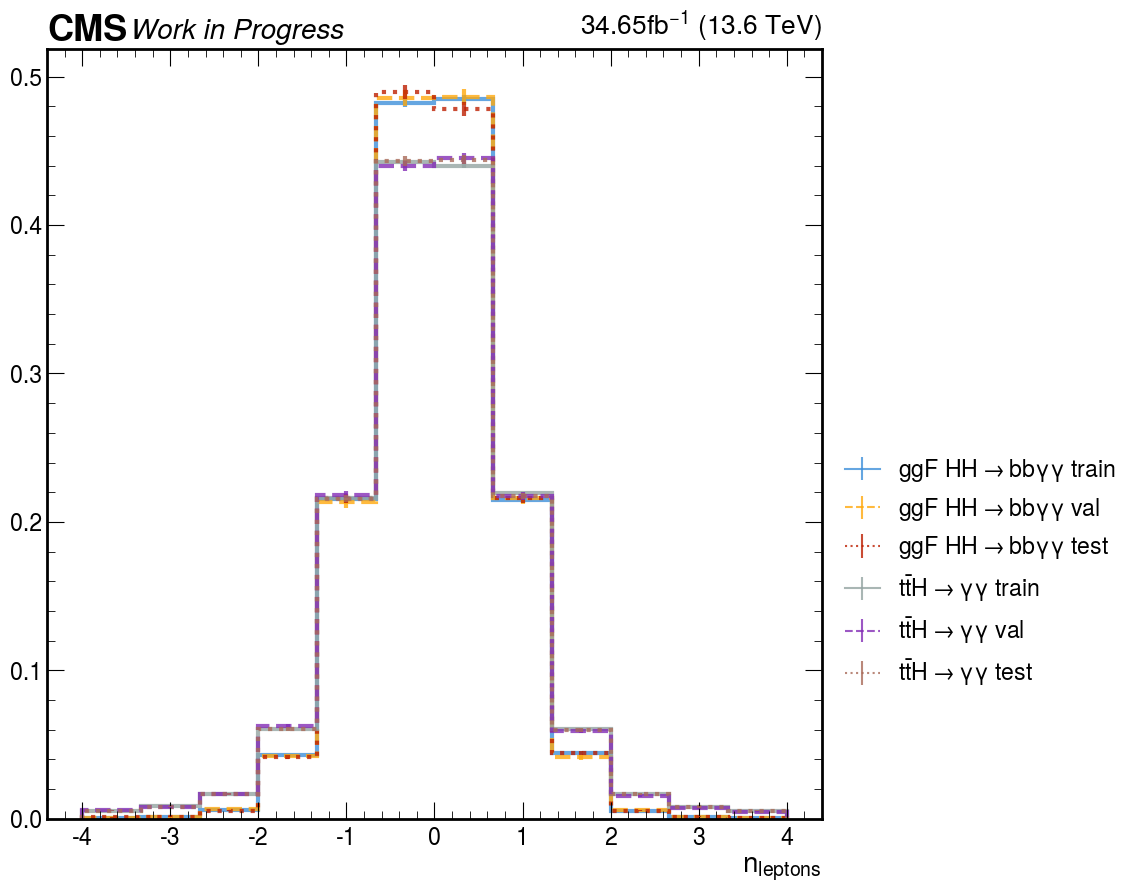

In [19]:
# output_dir_gauss_smear = CURRENT_DIRPATH + f"/input_comparison{'_v2' if V2_MERGED else ''}/{VERSION}{'_RNN' if re.search('vars_to_RNN', VARS) is not None else ''}/gauss_smear/"
output_dir_gauss_smear = CURRENT_DIRPATH + f"/input_comparison_v3/{VERSION}{'_RNN' if re.search('vars_to_RNN', VARS) is not None else ''}/gauss_smear/"
if not os.path.exists(output_dir_gauss_smear):
    os.makedirs(output_dir_gauss_smear)

gauss_hists = {}
label_arr = [
    MC_NAMES_PRETTY["GluGluToHH"]+" train", MC_NAMES_PRETTY["GluGluToHH"]+" test",
    MC_NAMES_PRETTY["ttHToGG"]+" train", MC_NAMES_PRETTY["ttHToGG"]+" test"
]
label_arr_fold = [
    MC_NAMES_PRETTY["GluGluToHH"]+" train", MC_NAMES_PRETTY["GluGluToHH"]+" val", MC_NAMES_PRETTY["GluGluToHH"]+" test",
    MC_NAMES_PRETTY["ttHToGG"]+" train", MC_NAMES_PRETTY["ttHToGG"]+" val", MC_NAMES_PRETTY["ttHToGG"]+" test"
]
for var_name in high_level_fields_dict['fold_0']:
    if var_name in {'event', 'puppiMET_eta'}:
        continue

    gauss_data_list_dict, gauss_data_hlf_dict = None, None
    if var_name in (high_level_fields_dict['fold_0'] - set(input_hlf_vars_dict['fold_0'])):
        gauss_data_list_dict = {
            f"fold_{fold_idx}": smear_particle_list(var_name, copy.deepcopy(data_list_dict[f"fold_{fold_idx}"])) for fold_idx in range(len(data_list_dict))
        }
        gauss_data_hlf_dict = data_hlf_dict

        gauss_data_list_test_dict = {
            f"fold_{fold_idx}": smear_particle_list(var_name, copy.deepcopy(data_list_test_dict[f"fold_{fold_idx}"])) for fold_idx in range(len(data_list_test_dict))
        }
        gauss_data_hlf_test_dict = data_hlf_test_dict
    else:
        gauss_data_list_dict = data_list_dict
        gauss_data_hlf_dict = {
            f"fold_{fold_idx}": smear_particle_hlf(var_name, copy.deepcopy(data_hlf_dict[f"fold_{fold_idx}"])) for fold_idx in range(len(data_hlf_dict))
        }

        gauss_data_list_test_dict = data_list_test_dict
        gauss_data_hlf_test_dict = {
            f"fold_{fold_idx}": smear_particle_hlf(var_name, copy.deepcopy(data_hlf_test_dict[f"fold_{fold_idx}"])) for fold_idx in range(len(data_hlf_test_dict))
        }
    
    for fold_idx in range(len(data_list_dict)):
        all_indices = np.arange(np.shape(data_list_dict[f'fold_{fold_idx}'])[0])
        (
            train_data_list, val_data_list,
            train_data_hlf, val_data_hlf,
            train_label, val_label,
            train_weight, val_weight,
            train_indices, val_indices
        ) = train_test_split(
            data_list_dict[f'fold_{fold_idx}'], data_hlf_dict[f'fold_{fold_idx}'], label_dict[f'fold_{fold_idx}'], 
            training_weights(data_aux_dict[f'fold_{fold_idx}'].loc[:, "eventWeight"].to_numpy(), label_dict[f'fold_{fold_idx}']),
            all_indices,
            test_size=0.2, random_state=SEED
        )
        train_mask = np.ones_like(all_indices, dtype=bool)
        train_mask[val_indices] = np.zeros_like(val_indices, dtype=bool)
        val_mask = np.logical_not(train_mask)

        data, data_test = None, None
        if var_name in (high_level_fields_dict['fold_0'] - set(input_hlf_vars_dict['fold_0'])):
            data, data_test = gauss_data_list_dict[f'fold_{fold_idx}'], gauss_data_list_test_dict[f'fold_{fold_idx}']
        else:
            data, data_test = gauss_data_hlf_dict[f'fold_{fold_idx}'], gauss_data_hlf_test_dict[f'fold_{fold_idx}']
        
        (
            sig_train_np, sig_val_np, sig_test_np, 
            bkg_train_np, bkg_val_np, bkg_test_np 
        ) = post_std_np_arrays(
            data, data_test, fold_idx, var_name,
            train_index=train_mask, val_index=val_mask
        )
        if re.search('lepton1', var_name) is not None or re.search('lepton2', var_name) is not None:
            sig_train_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_train_np[sig_train_np != 0])
            sig_val_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_val_np[sig_val_np != 0])
            sig_test_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_test_np[sig_test_np != 0])
            bkg_train_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_train_np[bkg_train_np != 0])
            bkg_val_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_val_np[bkg_val_np != 0])
            bkg_test_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_test_np[bkg_test_np != 0])
        else:
            sig_train_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_train_np)
            sig_val_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_val_np)
            sig_test_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_test_np)
            bkg_train_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_train_np)
            bkg_val_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_val_np)
            bkg_test_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_test_np)

        make_input_plot(
            output_dir_gauss_smear, var_name, 
            [sig_train_hist, sig_val_hist, sig_test_hist, bkg_train_hist, bkg_val_hist, bkg_test_hist], 
            fold_idx=fold_idx, labels=label_arr_fold
        )

### Mass sculpting

In [ ]:
# with open('model_outputs/v0/BestConfigReallyTopclass.json', 'r') as f:
# with open(OUTPUT_DIRPATH + CURRENT_TIME + '_BestConfigReallyTopclass.json') as f:
with open('/uscms/home/tsievert/nobackup/XHYbbgg/HHtobbyy/model_outputs/v4/extra_vars/2024-08-20_23-02-48_BestConfigReallyTopclass.json') as f:
# with open(os.path.join(OUTPUT_DIRPATH, 'ttH_Killer_IN_config.json'), 'r') as f:
    best_conf = json.load(f)
    print(best_conf)

weight_dict = {
    f'fold_{fold_idx}': copy.deepcopy(data_aux_dict[f'fold_{fold_idx}'].loc[:, "eventWeight"].to_numpy()) for fold_idx in range(len(data_aux_dict))
}
weight_test_dict = {
    f'fold_{fold_idx}': copy.deepcopy(data_test_aux_dict[f'fold_{fold_idx}'].loc[:, "eventWeight"].to_numpy()) for fold_idx in range(len(data_test_aux_dict))
}

IN_full_eval_dict = {}
for data_type, p_list, hlf, y, w2 in [('train', data_list_dict, data_hlf_dict, label_dict, weight_dict), ('test', data_list_test_dict, data_hlf_test_dict, label_test_dict, weight_test_dict)]:
    IN_full_eval_dict[data_type] = evaluate(
        p_list, hlf, y, w2,
        OUTPUT_DIRPATH, CURRENT_TIME, None, best_conf,
        save=True, dict_lists=True,
    )

with open(os.path.join(OUTPUT_DIRPATH, f'{CURRENT_TIME}_IN_perf_full_eval.json'), 'w') as f:
    json.dump(IN_full_eval_dict, f)

{'hidden_layers': 2, 'initial_nodes': 500, 'dropout': 0.27817607062770483, 'gru_layers': 2, 'gru_size': 500, 'dropout_g': 0.6184468141076988, 'learning_rate': 0.004851812500501461, 'batch_size': 4000, 'L2_reg': 0.0001}


/uscms/home/tsievert/nobackup/miniforge3/envs/higgs-dna/lib/python3.10/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/uscms/home/tsievert/nobackup/miniforge3/envs/higgs-dna/lib/python3.10/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


##### Mass dists with successive score cuts

In [ ]:
with open(os.path.join(OUTPUT_DIRPATH, f'{CURRENT_TIME}_IN_perf_full_eval.json'), 'r') as f:
    IN_full_eval_dict = json.load(f)

plot_destdir = os.path.join(OUTPUT_DIRPATH, 'plots/mass_sculpting_check')
if not os.path.exists(plot_destdir):
    os.makedirs(plot_destdir)

score_cuts = [0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.99]
label_arr = [
    MC_NAMES_PRETTY["GluGluToHH"]+" train, score cut = ", MC_NAMES_PRETTY["GluGluToHH"]+" test, score cut = ",
    MC_NAMES_PRETTY["ttHToGG"]+" train, score cut = ", MC_NAMES_PRETTY["ttHToGG"]+" test, score cut = "
] * len(score_cuts)
label_arr = [label_arr[label_idx]+str(score_cuts[score_idx // (len(label_arr)//len(score_cuts))]) for score_idx, label_idx in enumerate(range(len(label_arr)))]
hist_dict = {fold_idx: {'mass': [], 'dijet_mass': []} for fold_idx in range(len(data_aux_dict))}
for var_name in hist_dict[0].keys():
    for fold_idx in range(len(data_aux_dict)):
        for i, score_cut in enumerate(score_cuts):
            sig_train_np, sig_test_np, bkg_train_np, bkg_test_np = aux_np_arrays(var_name, score_cut, IN_full_eval_dict, fold_idx)
            sig_train_hist = hist.Hist(VARIABLES[var_name]).fill(var=sig_train_np)
            sig_test_hist = hist.Hist(VARIABLES[var_name]).fill(var=sig_test_np)
            bkg_train_hist = hist.Hist(VARIABLES[var_name]).fill(var=bkg_train_np)
            bkg_test_hist = hist.Hist(VARIABLES[var_name]).fill(var=bkg_test_np)
            hist_dict[fold_idx][var_name].extend(
                [
                    copy.deepcopy(sig_train_hist), copy.deepcopy(sig_test_hist), 
                    copy.deepcopy(bkg_train_hist), copy.deepcopy(bkg_test_hist)
                ]
            )
        for mod_factor, label_mod in enumerate(['sig_train', 'sig_test', 'bkg_train', 'bkg_test']):
            plot_list = []
            label_list = []
            for i in range(len(hist_dict[fold_idx][var_name])):
                if (i - mod_factor) % 4 == 0:
                    plot_list.append(hist_dict[fold_idx][var_name][i])
                    label_list.append(label_arr[i])
            make_input_plot(
                plot_destdir, var_name, plot_list, labels=label_list, density=True, 
                plot_prefix=CURRENT_TIME+'_', plot_postfix='_'+label_mod, alpha=0.5,
                linestyle=False, fold_idx=fold_idx
            )

### Train dataset size plot

In [ ]:
train_size_dirs = glob.glob(OUTPUT_DIRPATH[:-1]+'_mod*') + [OUTPUT_DIRPATH[:-1]]
final_train_losses_arr, final_val_losses_arr = [], []
mod_values_arr = []

for train_size_dir in train_size_dirs:
    if len(glob.glob(train_size_dir + '/*IN_perf.json')) == 0:
        continue
    try:
        mod_values_arr.append([
            float(
                train_size_dir[
                    train_size_dir.find('_mod')+4 : train_size_dir.find('-')
                ]
            ),
            float(
                train_size_dir[train_size_dir.find('-')+1:]
            )
        ])
    except:
         mod_values_arr.append([2, 2])
    IN_perf_path = glob.glob(f'{train_size_dir}/*IN_perf.json')[0]
    with open(IN_perf_path, 'r') as f:
        IN_perf = json.load(f)
    final_train_losses_arr.append([train_losses[-7 if len(train_losses) < NUM_EPOCHS else -1] for train_losses in IN_perf['train_losses_arr']])
    final_val_losses_arr.append([val_losses[-7 if len(val_losses) < NUM_EPOCHS else -1] for val_losses in IN_perf['val_losses_arr']])

final_train_losses_arr = np.array(final_train_losses_arr)
final_val_losses_arr = np.array(final_val_losses_arr)
mod_values_arr = np.array(mod_values_arr)
dataset_sizes = (len(label) + len(label_test)) / mod_values_arr
sorted_indices = np.argsort(dataset_sizes[:, 0])

plot_destdir = OUTPUT_DIRPATH + 'plots/' + CURRENT_TIME
if not os.path.exists(plot_destdir):
    os.makedirs(plot_destdir)

plt.plot(
    dataset_sizes[:, 0][sorted_indices], np.mean(final_train_losses_arr, axis=1)[sorted_indices], color='k'
)
plt.fill_between(
    dataset_sizes[:, 0][sorted_indices], (np.mean(final_train_losses_arr, axis=1)-np.std(final_train_losses_arr, axis=1))[sorted_indices], 
    (np.mean(final_train_losses_arr, axis=1)+np.std(final_train_losses_arr, axis=1))[sorted_indices], 
    color=cmap_petroff10[0], alpha=0.5, label='Train data'
)
plt.plot(
    dataset_sizes[:, 0][sorted_indices], np.mean(final_val_losses_arr, axis=1)[sorted_indices], color='k'
)
plt.fill_between(
    dataset_sizes[:, 0][sorted_indices], (np.mean(final_val_losses_arr, axis=1)-np.std(final_val_losses_arr, axis=1))[sorted_indices], 
    (np.mean(final_val_losses_arr, axis=1)+np.std(final_val_losses_arr, axis=1))[sorted_indices], 
    color=cmap_petroff10[1], alpha=0.5, label='Val data'
)
plt.xlabel('Size of train dataset')
plt.ylabel('Loss')
plt.legend()
plt.savefig(plot_destdir + '/train_val_comparison_varying_trainset_size.pdf')
plt.savefig(plot_destdir + '/train_val_comparison_varying_trainset_size.png')
plt.close()